In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import os
from utils import data_loader_utils
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsfresh import extract_features
from tsfresh import select_features
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, roc_auc_score
from tsfresh import select_features, extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.feature_calculators import (skewness, kurtosis, minimum, maximum, standard_deviation, approximate_entropy)
from tsfresh.feature_extraction import MinimalFCParameters
from pathlib import Path
import shutil
from scipy.signal import spectrogram


In [13]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = "../../cnc_data/Whole"

In [14]:
X_data = []
y_data = []
for process_name in process_names:
    for machine in machines:
        for label in labels:
            data_path = os.path.join(path_to_dataset, machine, process_name, label)
            data_list, data_label = data_loader_utils.load_tool_research_data(data_path, add_additional_label=False, label=label)
            #concatenating
            X_data.extend(data_list)
            y_data.extend(data_label)

laoding files from ../../cnc_data/Whole\M01\OP00\good... 
laoding files from ../../cnc_data/Whole\M01\OP00\bad... 
laoding files from ../../cnc_data/Whole\M02\OP00\good... 
laoding files from ../../cnc_data/Whole\M02\OP00\bad... 
laoding files from ../../cnc_data/Whole\M03\OP00\good... 
laoding files from ../../cnc_data/Whole\M03\OP00\bad... 
laoding files from ../../cnc_data/Whole\M01\OP01\good... 
laoding files from ../../cnc_data/Whole\M01\OP01\bad... 
laoding files from ../../cnc_data/Whole\M02\OP01\good... 
laoding files from ../../cnc_data/Whole\M02\OP01\bad... 
laoding files from ../../cnc_data/Whole\M03\OP01\good... 
laoding files from ../../cnc_data/Whole\M03\OP01\bad... 
laoding files from ../../cnc_data/Whole\M01\OP02\good... 
laoding files from ../../cnc_data/Whole\M01\OP02\bad... 
laoding files from ../../cnc_data/Whole\M02\OP02\good... 
laoding files from ../../cnc_data/Whole\M02\OP02\bad... 
laoding files from ../../cnc_data/Whole\M03\OP02\good... 
laoding files from ../

In [15]:
good_X_data = []
good_y_data = []
bad_X_data = []
bad_y_data = []

for i, label in enumerate(y_data):
    if label == "good":
        good_X_data.append(X_data[i])
        good_y_data.append(label)
    elif label == "bad":
        bad_X_data.append(X_data[i])
        bad_y_data.append(label)
    else:
        # Handle other labels if necessary
        pass


In [17]:
len(bad_y_data)

70

In [18]:

# Load the HDF5 file
data_file = '../../cnc_data/Whole/M02/OP01/good/M02_Aug_2019_OP01_002.h5'  # Replace with the actual file path

with h5py.File(data_file, 'r') as file:
    # Extract the vibration data
    vibration_data = file['vibration_data'][:]

# Create a Pandas DataFrame with separate columns for X, Y, and Z
vibration_df = pd.DataFrame({'X': vibration_data[:, 0], 'Y': vibration_data[:, 1], 'Z': vibration_data[:, 2]})
time = len(vibration_df)/2000
# Display the first few rows of the DataFrame
print(vibration_df, time)

           X     Y       Z
0       17.0  -3.0 -1024.0
1       15.0  23.0 -1040.0
2        7.0  11.0 -1024.0
3       15.0   0.0 -1038.0
4        5.0  37.0 -1032.0
...      ...   ...     ...
57339   29.0  21.0 -1028.0
57340  144.0   1.0 -1069.0
57341   21.0 -52.0 -1089.0
57342  -81.0   9.0 -1044.0
57343  132.0   3.0 -1001.0

[57344 rows x 3 columns] 28.672


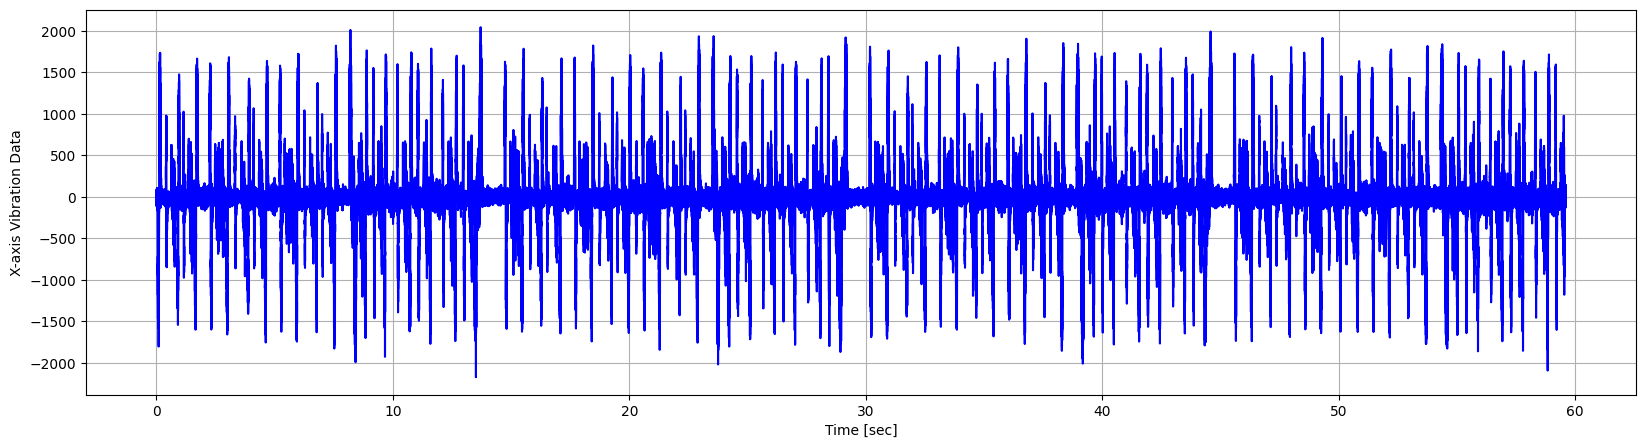

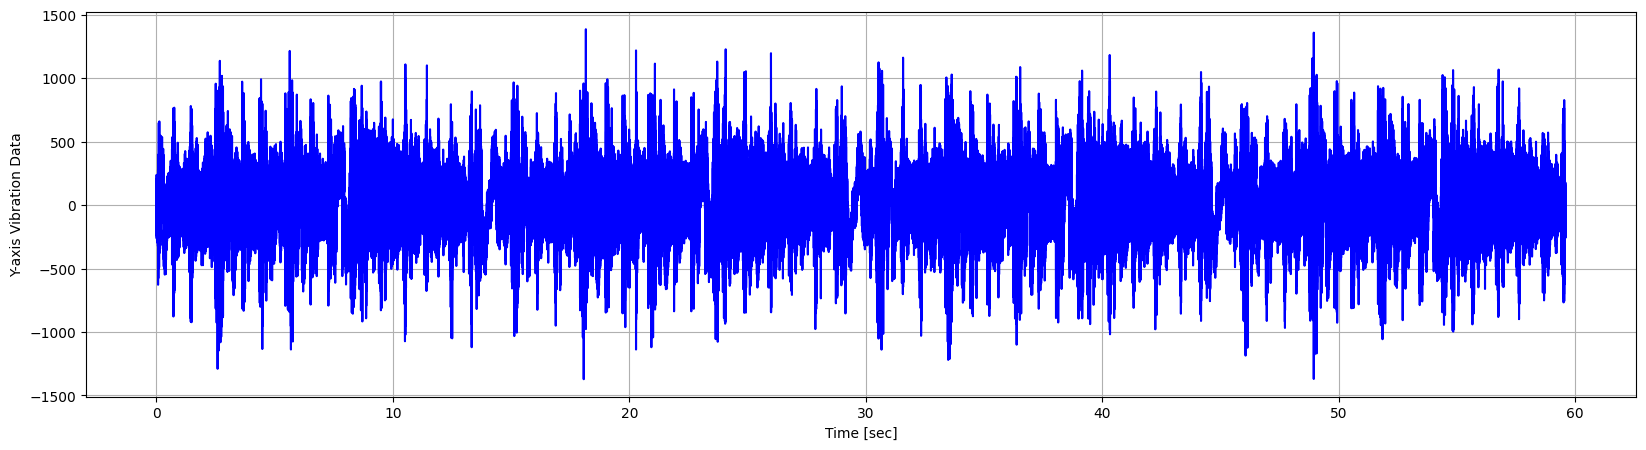

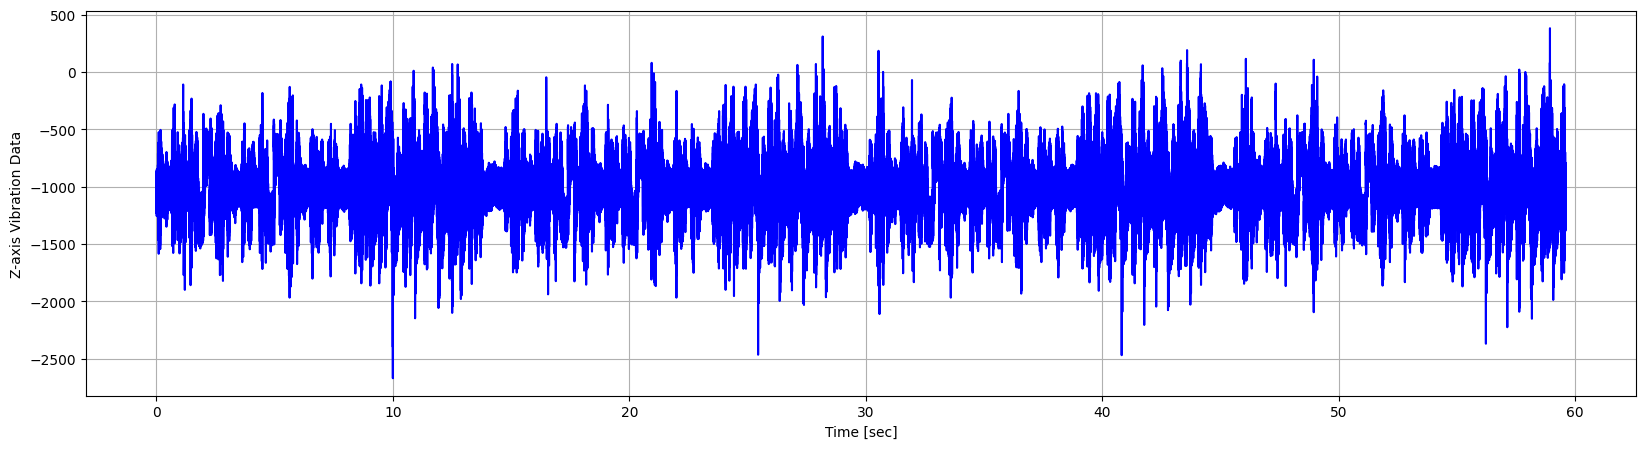

In [19]:


file= "../../cnc_data/Whole/M02/OP04/bad/M02_Aug_2019_OP04_000.h5"
sample = data_loader_utils.datafile_read(file)

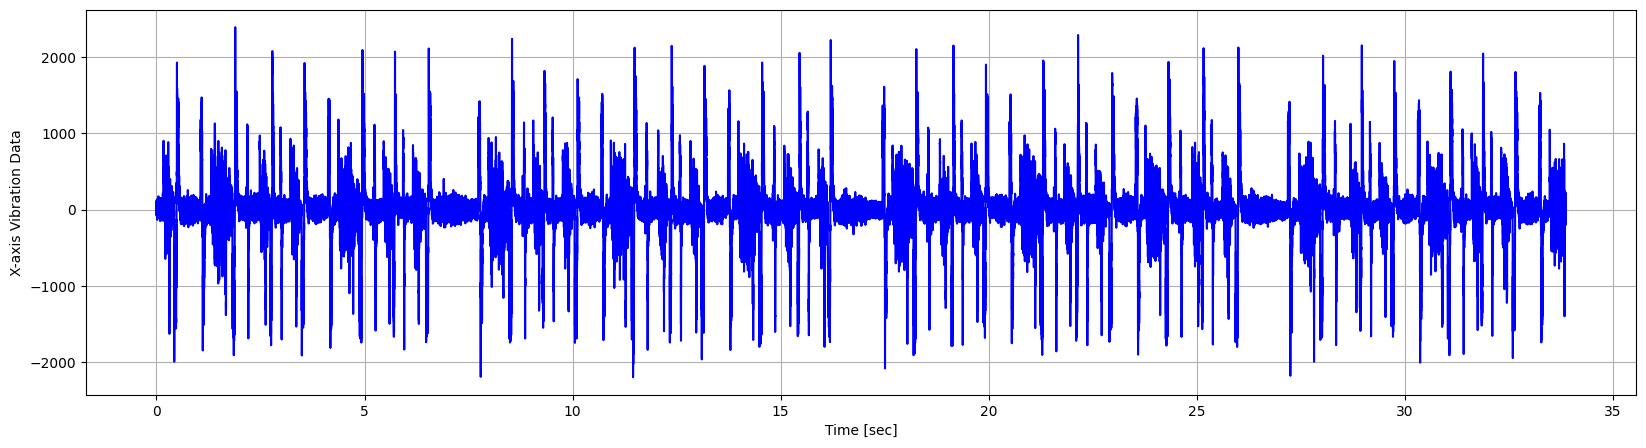

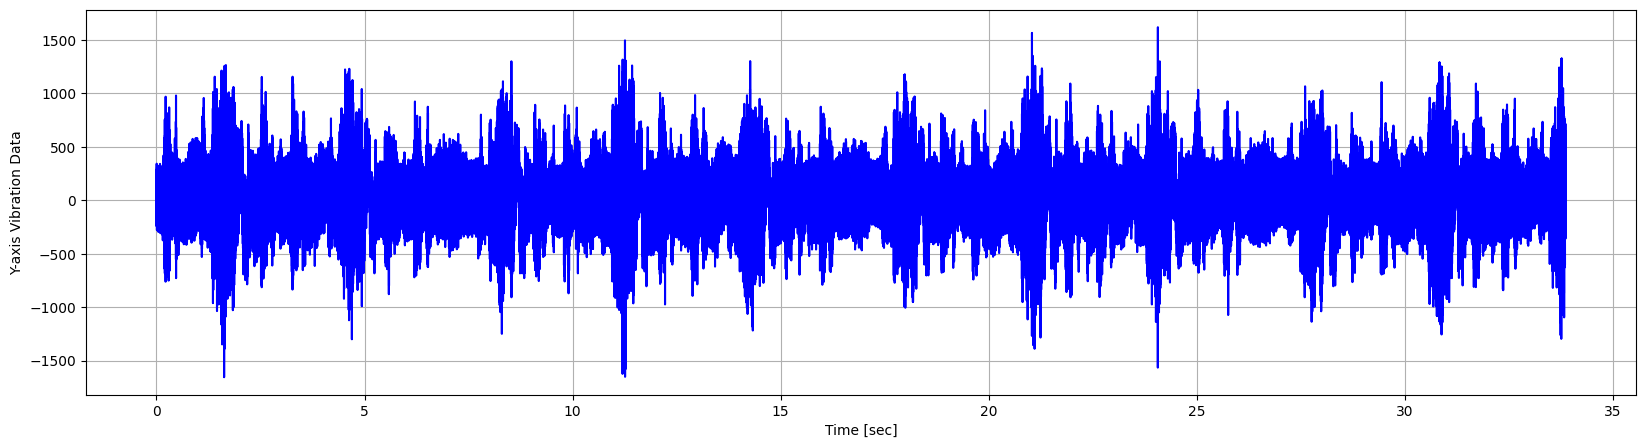

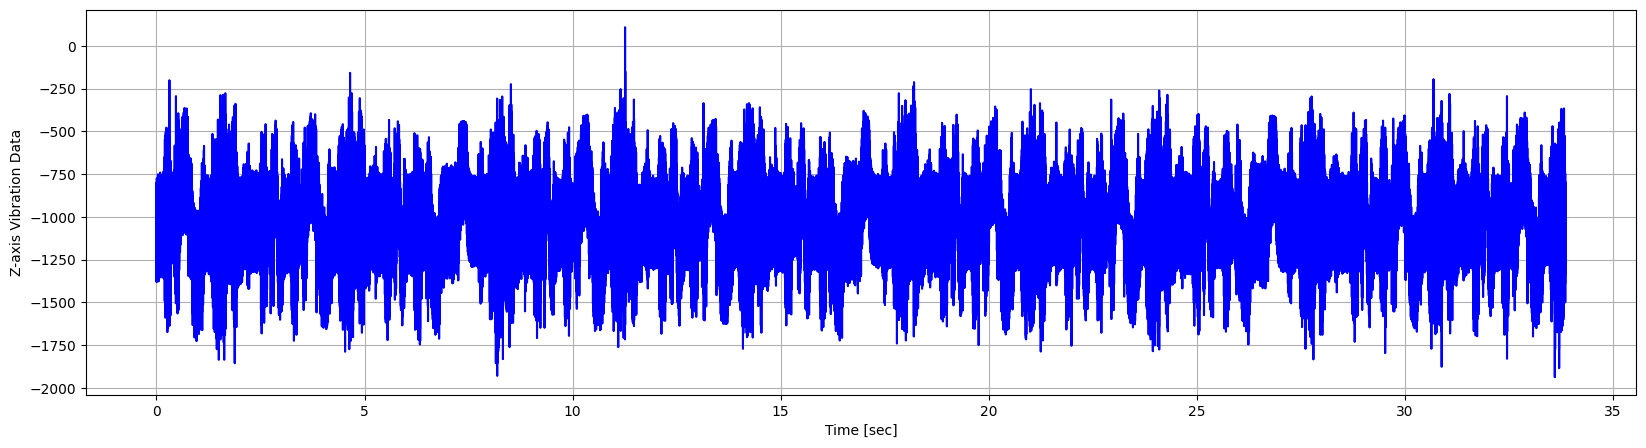

In [22]:
file= "../../cnc_data/Whole/M01/OP04/bad/M01_Aug_2019_OP04_000.h5"
sample = data_loader_utils.datafile_read(file)

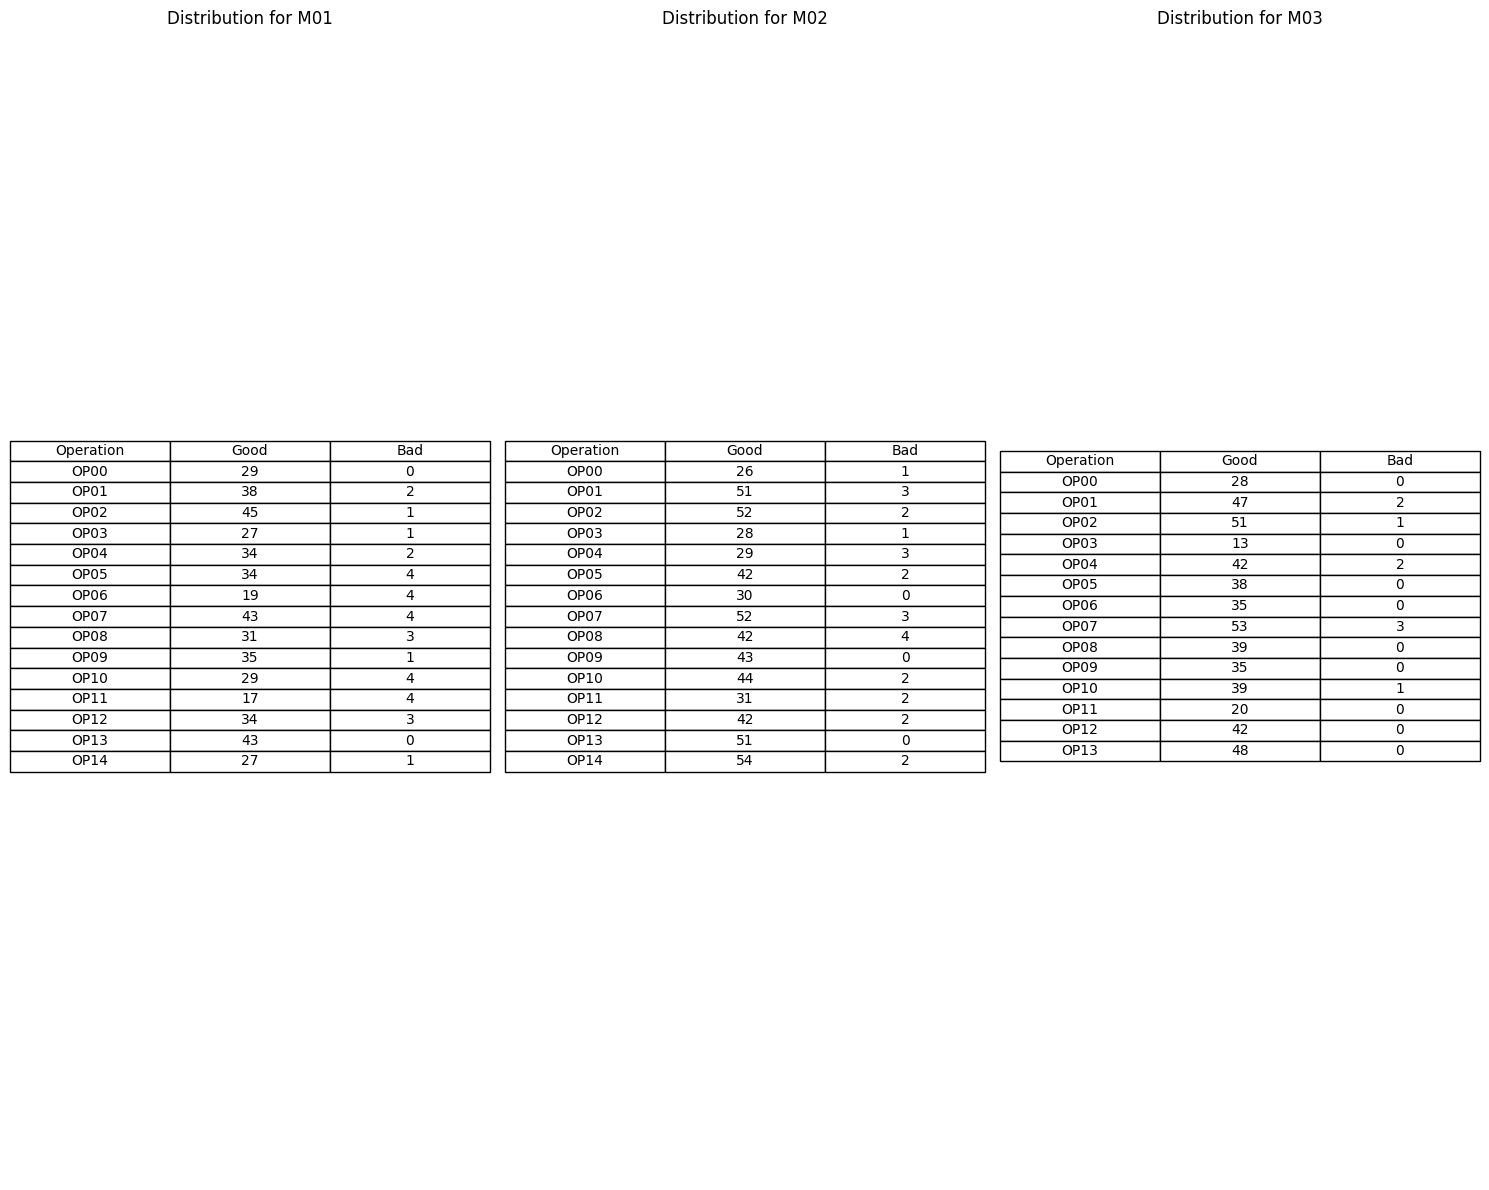

In [23]:


# Define the root directory where your data is stored
data_root = ("../../cnc_data/Whole/")



# Initialize counters
machine_operation_counts = []

# Iterate through the directory structure
for machine in ['M01', 'M02', 'M03']:
    for operation in os.listdir(os.path.join(data_root, machine)):
        if os.path.isdir(os.path.join(data_root, machine, operation)):
            good_count = len([file for file in os.listdir(os.path.join(data_root, machine, operation, 'good')) if file.endswith('.h5')])

            # Check if the 'bad' directory exists
            bad_directory = os.path.join(data_root, machine, operation, 'bad')
            if os.path.exists(bad_directory):
                bad_count = len([file for file in os.listdir(bad_directory) if file.endswith('.h5')])
            else:
                bad_count = 0

            machine_operation_counts.append({
                'Machine': machine,
                'Operation': operation,
                'Good': good_count,
                'Bad': bad_count
            })

# Convert the counts to a DataFrame for visualization
df = pd.DataFrame(machine_operation_counts)

# Sort the DataFrame by 'Operation'
df_sorted = df.sort_values(by='Operation')

# Get unique machine values
machines = df_sorted['Machine'].unique()



# Create three separate tables
fig, axes = plt.subplots(1, 3, figsize=(15, 12))


for i, machine in enumerate(machines):
    subset = df[df['Machine'] == machine]
    table_data = subset[['Operation', 'Good', 'Bad']]
    ax = axes[i]
    ax.axis('off')
    
    table = ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
    ax.set_title(f'Distribution for {machine}')

# Adjust the layout
plt.tight_layout()
plt.show()



In [24]:

# Define the root directory where your data is stored
data_root = "../../cnc_data/Whole/"

def find_all_h5s_in_dir(s_dir):
    """
    list all .h5 files in a directory
    """

    fileslist = []
    for root, dirs, files in os.walk(s_dir):
        for file in files:
            if file.endswith(".h5"):
                fileslist.append(file)
    return fileslist


# Define a function to load H5 files and calculate the duration in seconds
def load_h5_files_and_calculate_duration(data_root):
    data_list = []
    labels = []

    for machine in ['M01', 'M02', 'M03']:
        for operation in os.listdir(os.path.join(data_root, machine)):
            if os.path.isdir(os.path.join(data_root, machine, operation)):
                for label in ['good', 'bad']:
                    data_path = os.path.join(data_root, machine, operation, label)
                    files = find_all_h5s_in_dir(data_path)

                    for file in files:
                        file_path = os.path.join(data_path, file)
                        with h5py.File(file_path, 'r') as f:
                            vibration_data = f['vibration_data'][:]
                            samples_s = len(vibration_data) / 2000  # Assuming a data sampling frequency of 2000 Hz

                        data_list.append({
                            'Machine': machine,
                            'Operation': operation,
                            'Sample Type': label,
                            'File Name': file,
                            'Duration (s)': samples_s
                        })

    return data_list

# Create a DataFrame
data_list = load_h5_files_and_calculate_duration(data_root)
df = pd.DataFrame(data_list)

# Print the DataFrame
print(df)



     Machine Operation Sample Type                 File Name  Duration (s)
0        M01      OP00        good  M01_Aug_2019_OP00_000.h5       134.144
1        M01      OP00        good  M01_Aug_2019_OP00_001.h5       134.144
2        M01      OP00        good  M01_Aug_2019_OP00_003.h5       134.144
3        M01      OP00        good  M01_Aug_2019_OP00_004.h5       132.096
4        M01      OP00        good  M01_Aug_2019_OP00_005.h5       134.144
...      ...       ...         ...                       ...           ...
1697     M03      OP13        good  M03_Feb_2020_OP13_012.h5        33.280
1698     M03      OP13        good  M03_Feb_2020_OP13_013.h5        33.280
1699     M03      OP13        good  M03_Feb_2021_OP13_000.h5        33.280
1700     M03      OP13        good  M03_Feb_2021_OP13_001.h5        33.280
1701     M03      OP13        good  M03_Feb_2021_OP13_002.h5        31.744

[1702 rows x 5 columns]


In [57]:
csv_filename = 'dataset_selected_info.csv'
df.to_csv(csv_filename, index=False)

# Print a message to confirm the file has been saved
print(f"DataFrame saved to {csv_filename}")

DataFrame saved to dataset_selected_info.csv


In [26]:


def datafile_read(files, dataset_labels=None, plotting=True):
    """Loads and plots data from multiple datafiles in separate subplots for each axis with dataset labels.

    Keyword Arguments:
        files {list} -- List of file paths
        dataset_labels {list} -- List of dataset labels for legends (optional)

    Returns:
        list of ndarrays -- List of raw data arrays
    """
    all_data = []
    max_samples = 0

    for file in files:
        with h5py.File(file, 'r') as f:
            vibration_data = f['vibration_data'][:]
        all_data.append(vibration_data)
        max_samples = max(max_samples, len(vibration_data))

    # Interpolation for the x-axis plot
    freq = 2000
    samples_s = max_samples / freq
    samples = np.linspace(0, samples_s, max_samples)

    if plotting:
        fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

        for i, data in enumerate(all_data):
            if len(data) < max_samples:
                # Pad the shorter dataset with NaN values
                padding = np.full((max_samples - len(data), 3), np.nan)
                data = np.vstack((data, padding))
            
            if dataset_labels is not None:
                label = dataset_labels[i] if i < len(dataset_labels) else f'Dataset {i + 1}'
            else:
                label = f'Dataset {i + 1}'
            
            axs[0].plot(samples, data[:, 0], label=f'X-axis Vibration Data - {label}')
            axs[1].plot(samples, data[:, 1], label=f'Y-axis Vibration Data - {label}')
            axs[2].plot(samples, data[:, 2], label=f'Z-axis Vibration Data - {label}')

        axs[0].set_ylabel('X-axis Vibration Data')
        axs[1].set_ylabel('Y-axis Vibration Data')
        axs[2].set_ylabel('Z-axis Vibration Data')
        axs[2].set_xlabel('Time [sec]')

        for ax in axs:
            ax.locator_params(axis='y', nbins=10)
            ax.grid()
            ax.legend()

        plt.show()

    return all_data



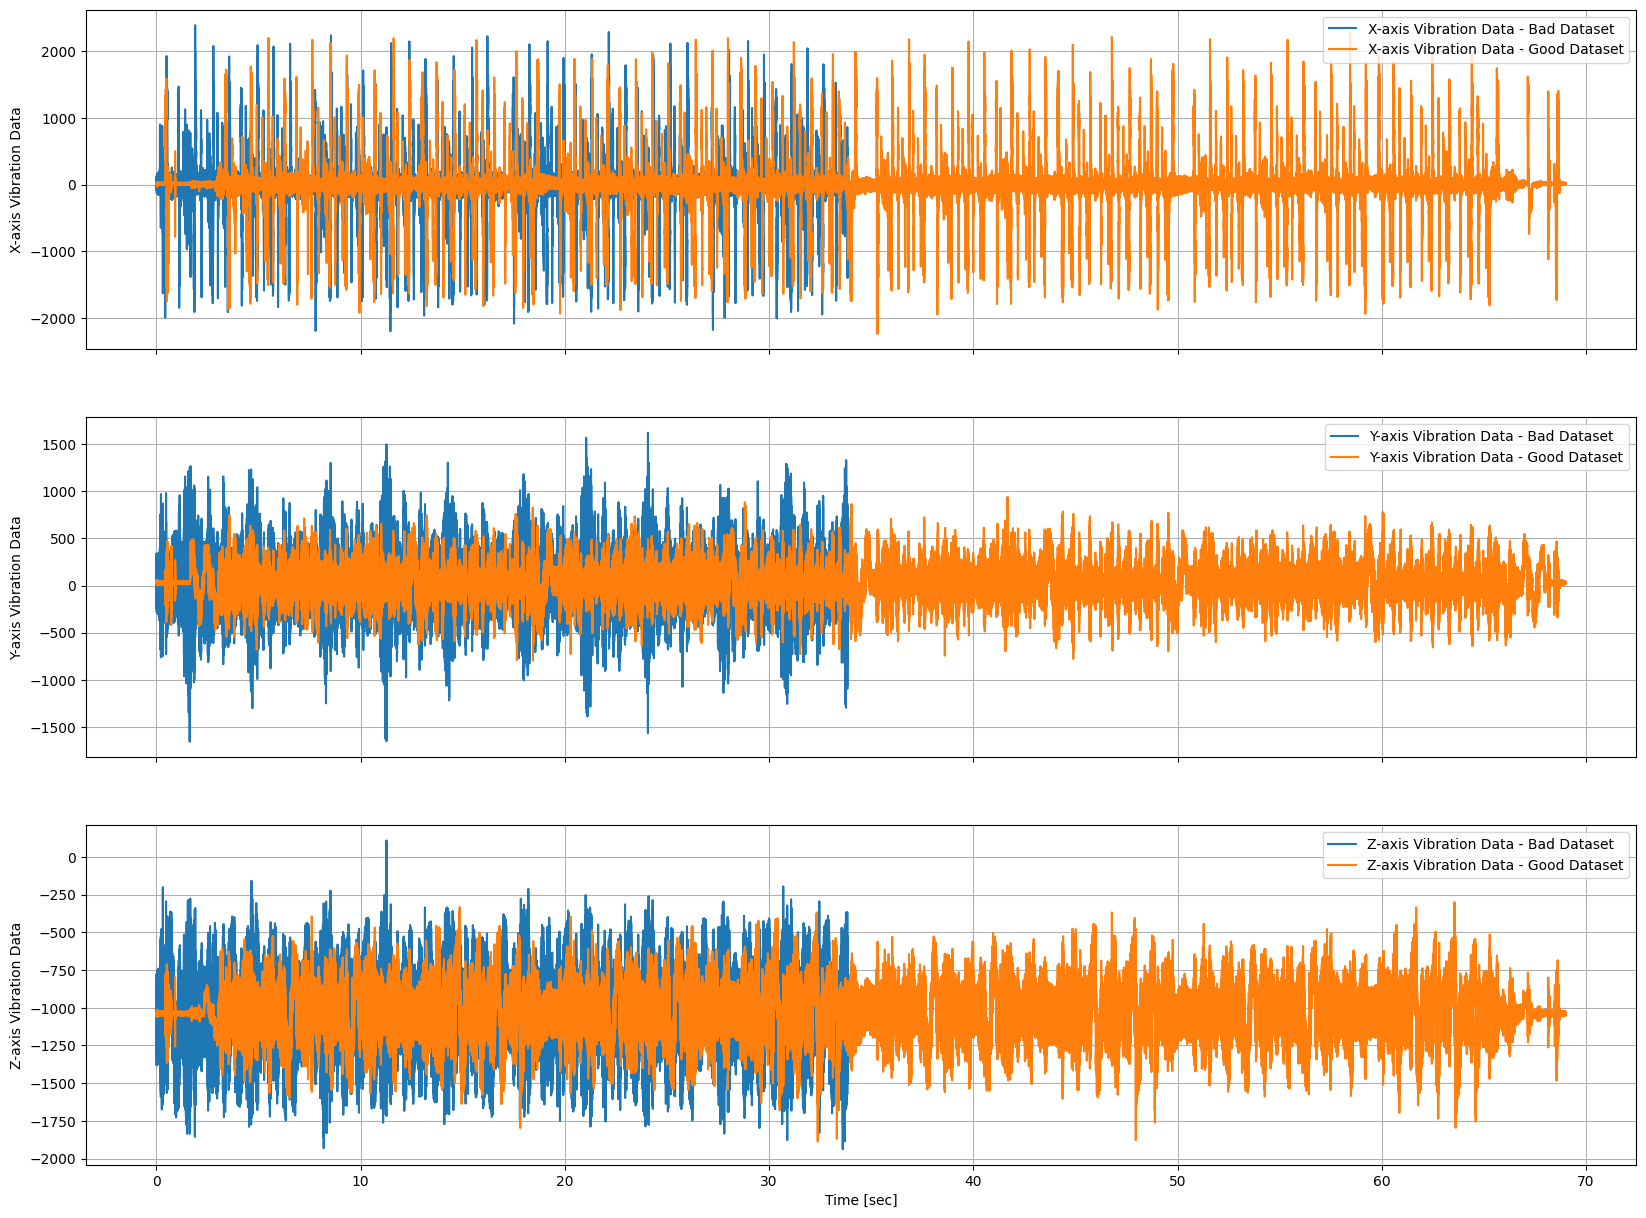

In [27]:
# Example usage:
files=['../../cnc_data/Whole//M01/OP04/bad/M01_Aug_2019_OP04_000.h5', '../../cnc_data/Whole/M01/OP04/good/M01_Feb_2019_OP04_000.h5']
dataset_labels = ["Bad Dataset", "Good Dataset"]  # Add labels for your datasets

data = datafile_read(files, dataset_labels)


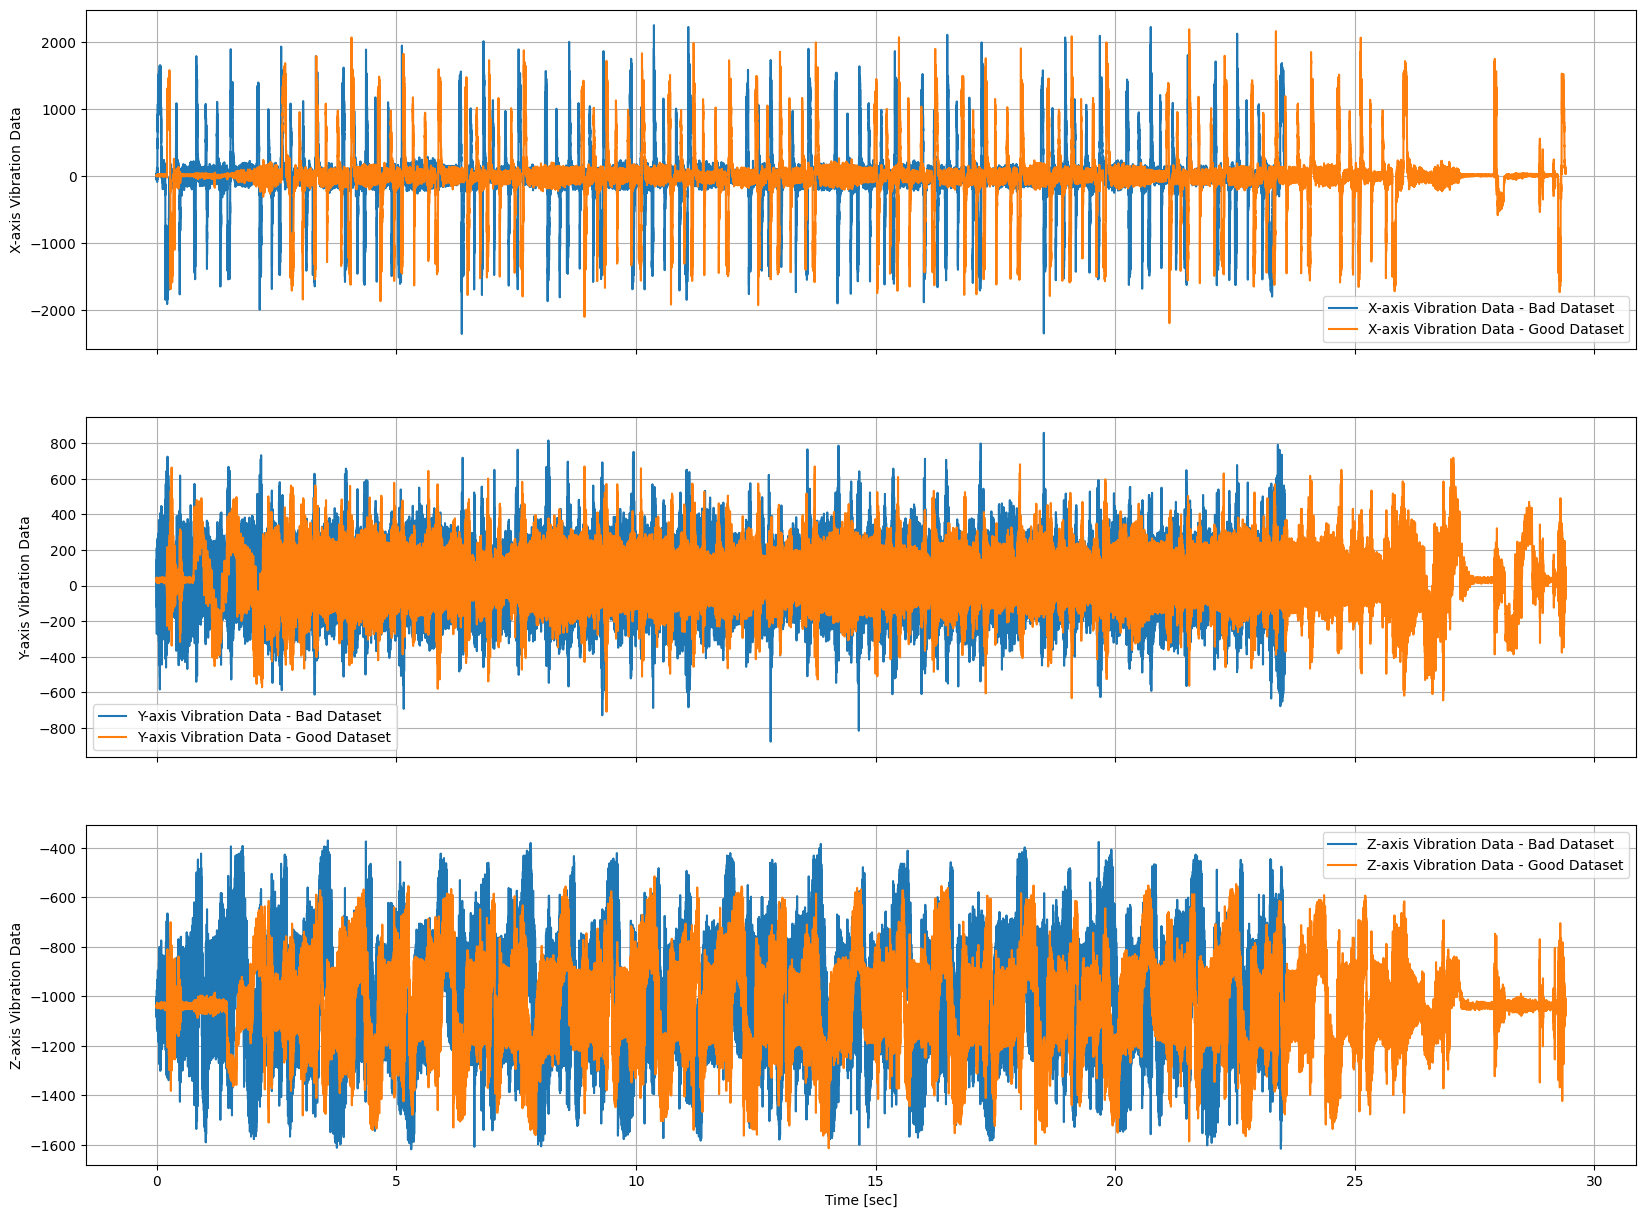

In [28]:
# Example usage:
files=['../../cnc_data/Whole/M01/OP01/bad/M01_Feb_2019_OP01_000.h5', '../../cnc_data/Whole/M01/OP01/good/M01_Feb_2019_OP01_001.h5']
dataset_labels = ["Bad Dataset", "Good Dataset"]  # Add labels for your datasets

data = datafile_read(files, dataset_labels)


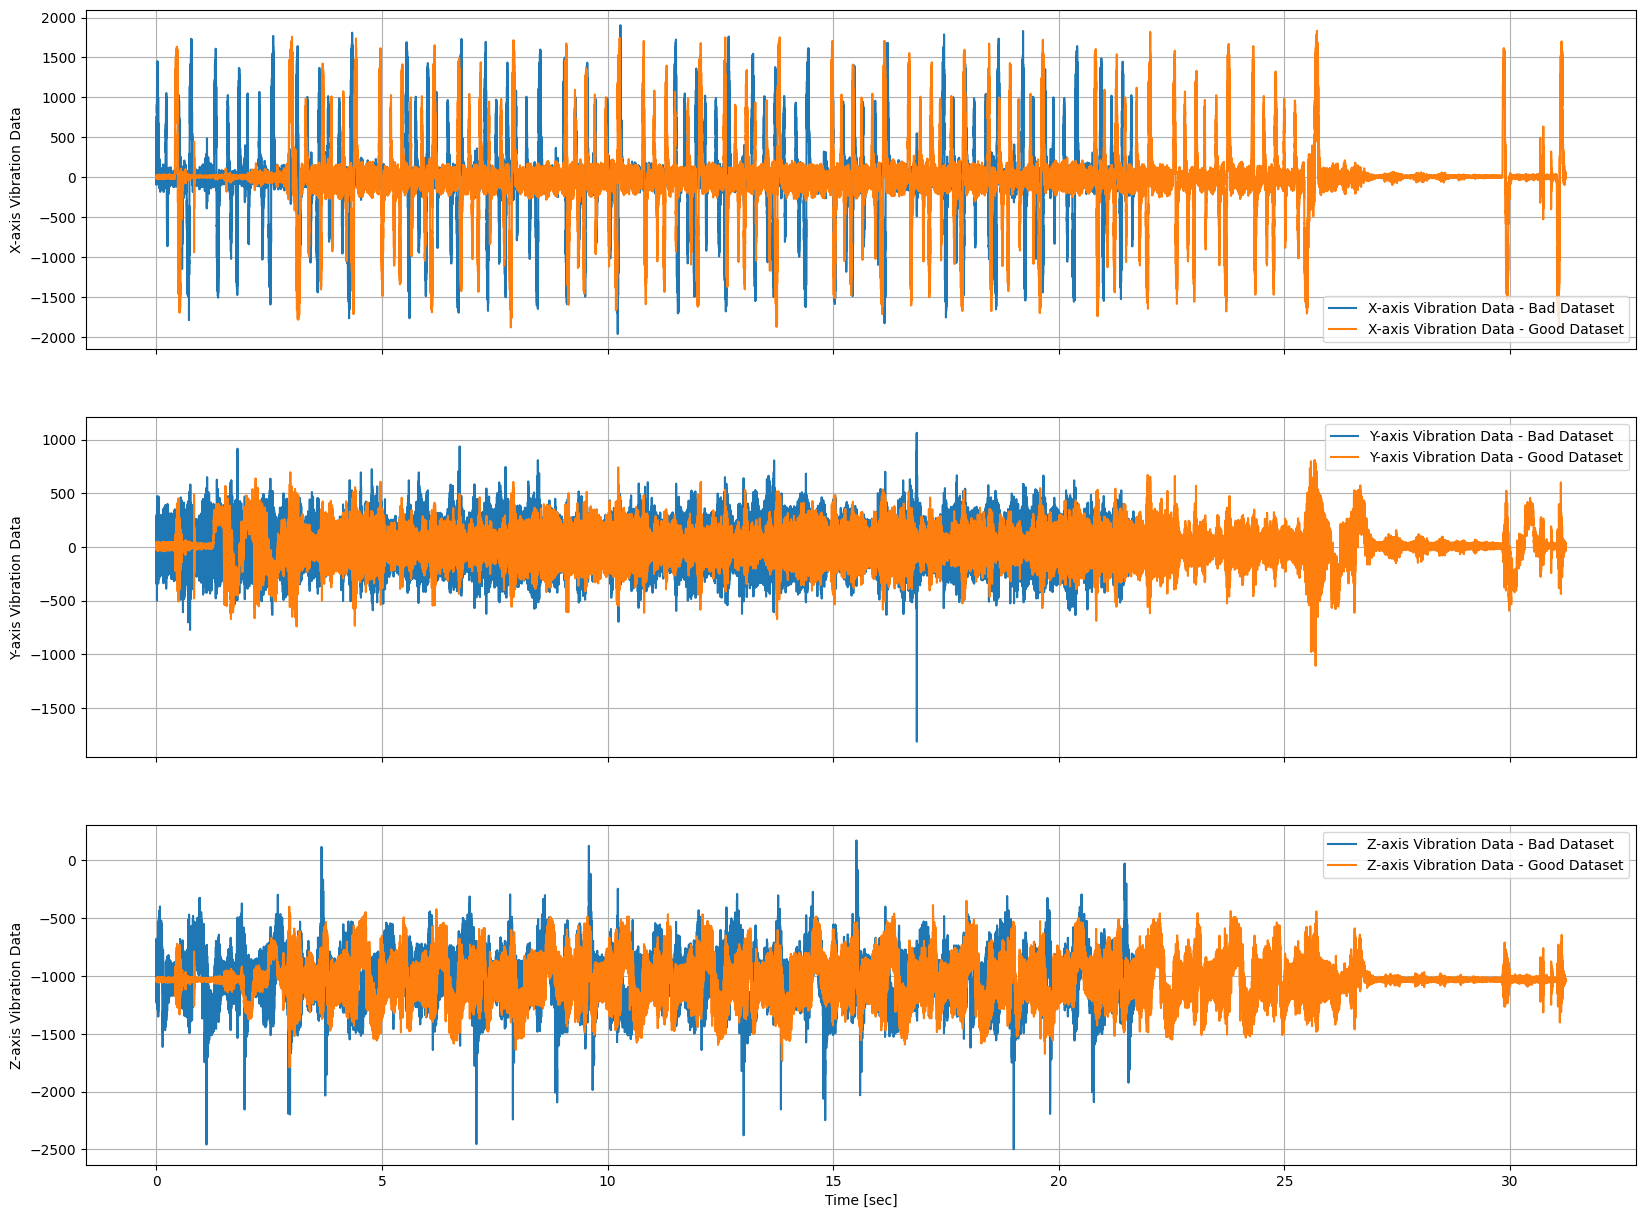

In [30]:
# Example usage:
files=['../../cnc_data/Whole/M02/OP01/bad/M02_Aug_2019_OP01_000.h5', '../../cnc_data/Whole/M02/OP01/good/M02_Feb_2021_OP01_001.h5']
dataset_labels = ["Bad Dataset", "Good Dataset"]  # Add labels for your datasets

data = datafile_read(files, dataset_labels)


In [31]:
def compute_fft(signal, sampling_rate=2000):
    """Calculates the FFT of a signal.

    Args:
        signal: The time-domain signal (a NumPy array).
        sampling_rate: The sampling rate of the signal in Hz.

    Returns:
        (frequencies, fft_values): A tuple containing:
            * frequencies: An array of frequencies corresponding to the FFT bins.
            * fft_values: An array of complex FFT values.
    """

    signal_length = len(signal)
    fft_values = np.fft.fft(signal)  # Calculate the FFT
    frequencies = np.fft.fftfreq(signal_length, d=1/sampling_rate)  # Frequencies

    # Keep only positive frequencies for real-world signals
    positive_indices = frequencies >= 0
    frequencies = frequencies[positive_indices]
    fft_values = fft_values[positive_indices]

    return frequencies, fft_values


E:\Thesis\Datasets\CNC\.venv_cnc\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
E:\Thesis\Datasets\CNC\.venv_cnc\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


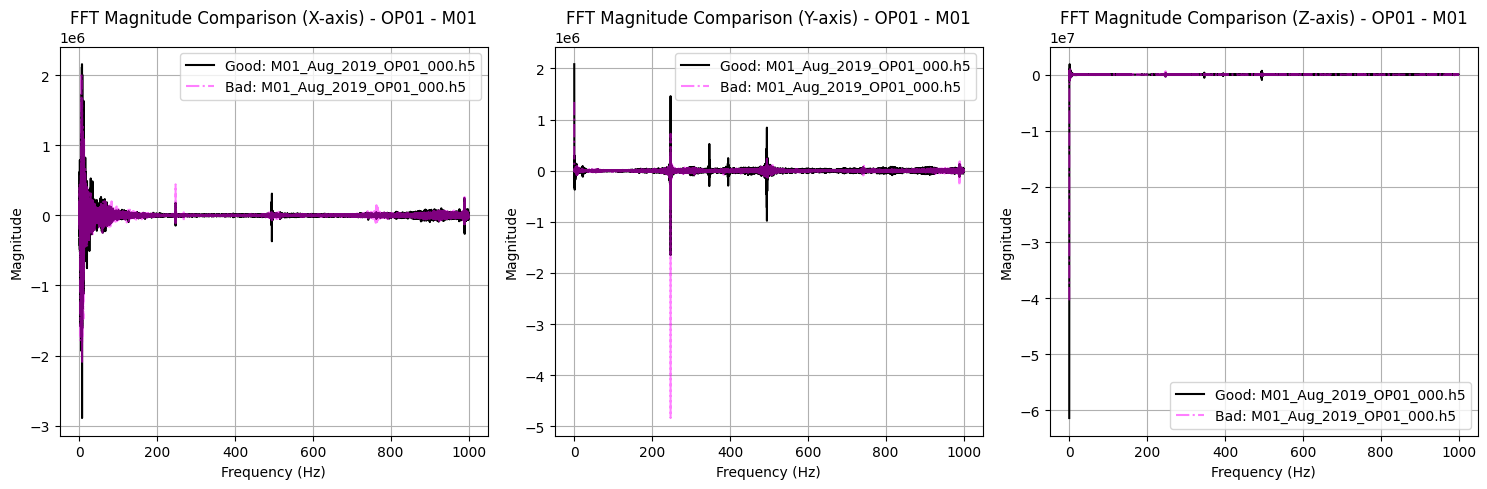

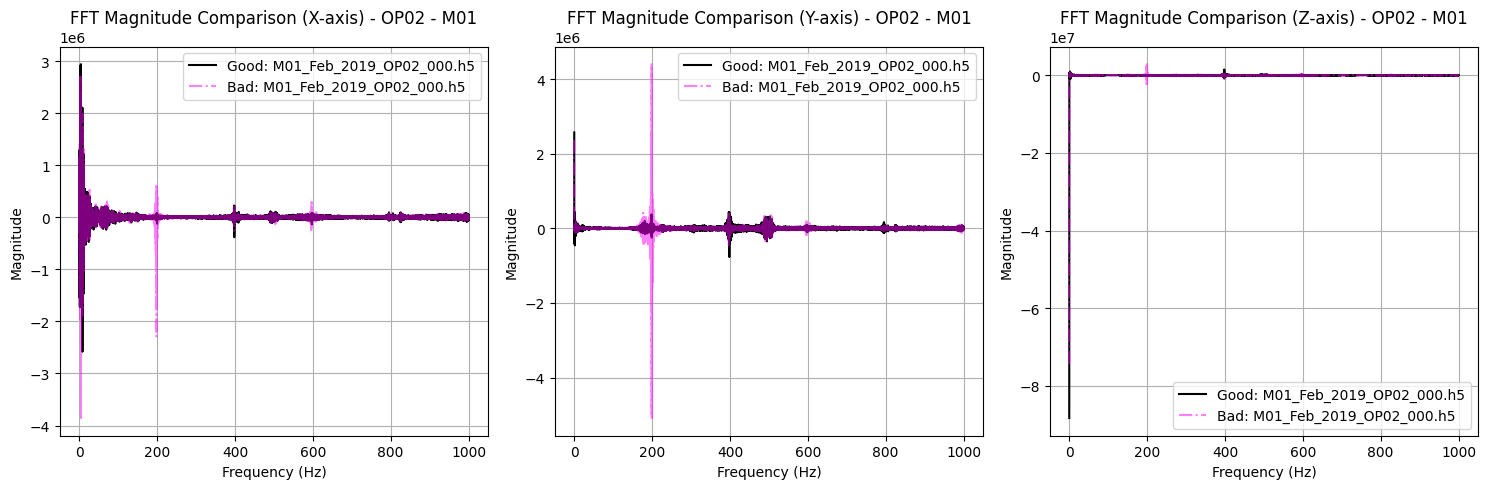

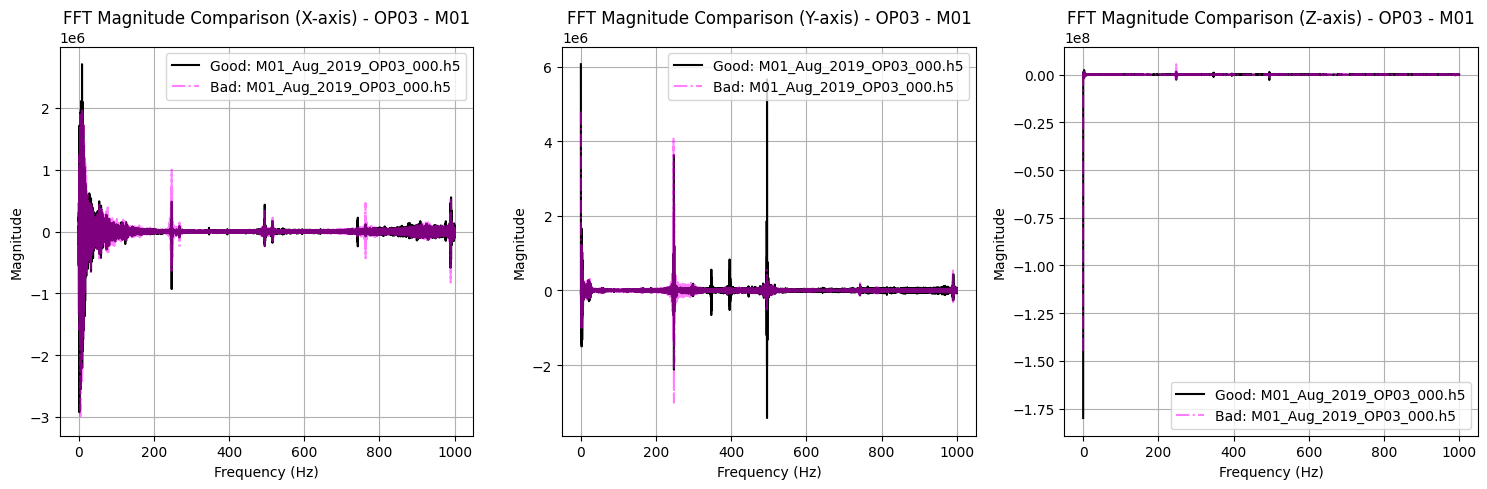

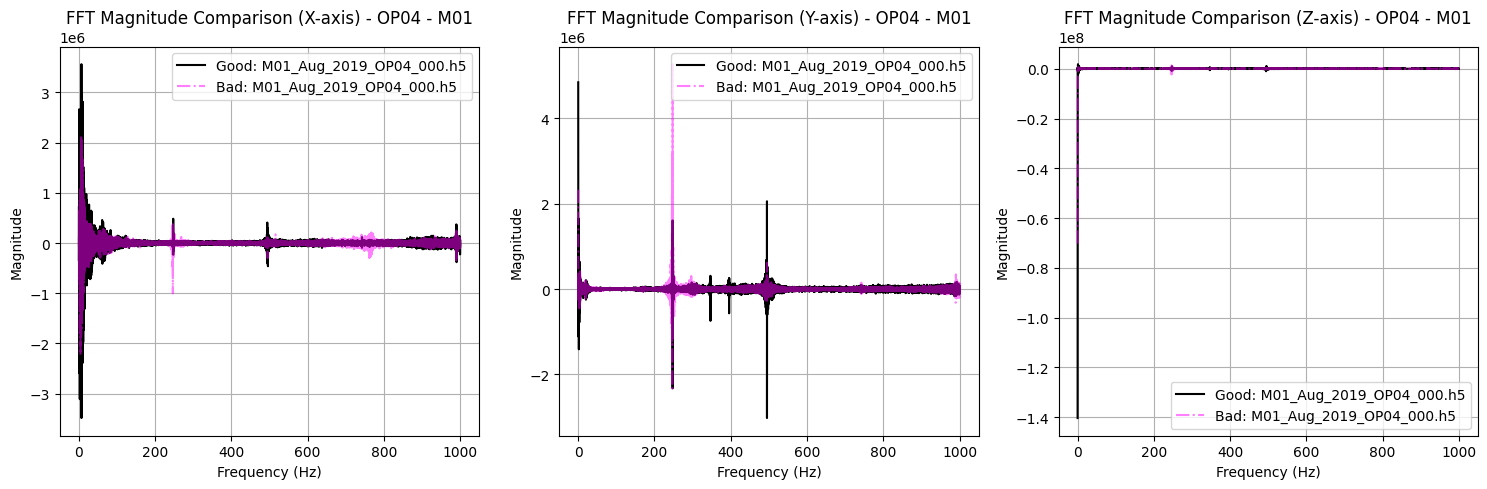

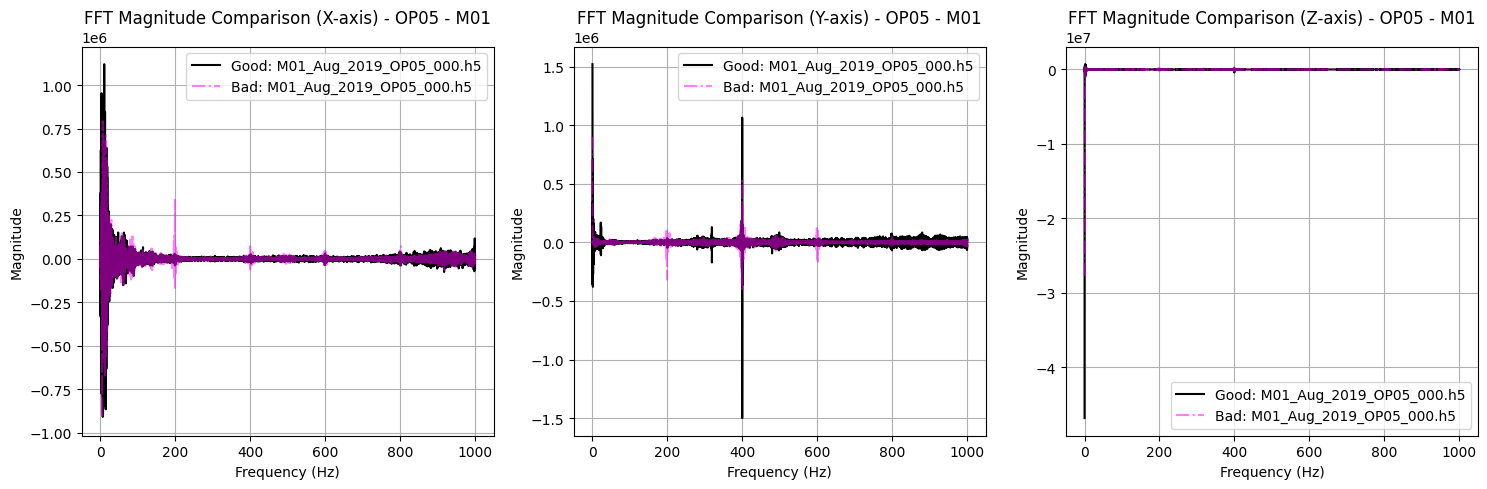

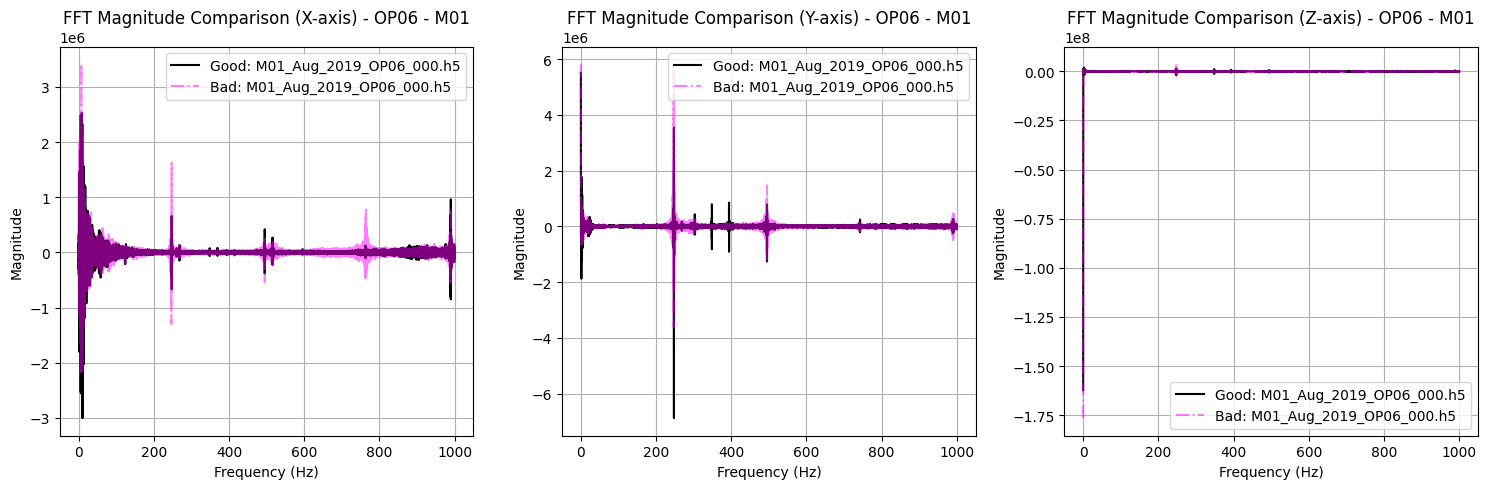

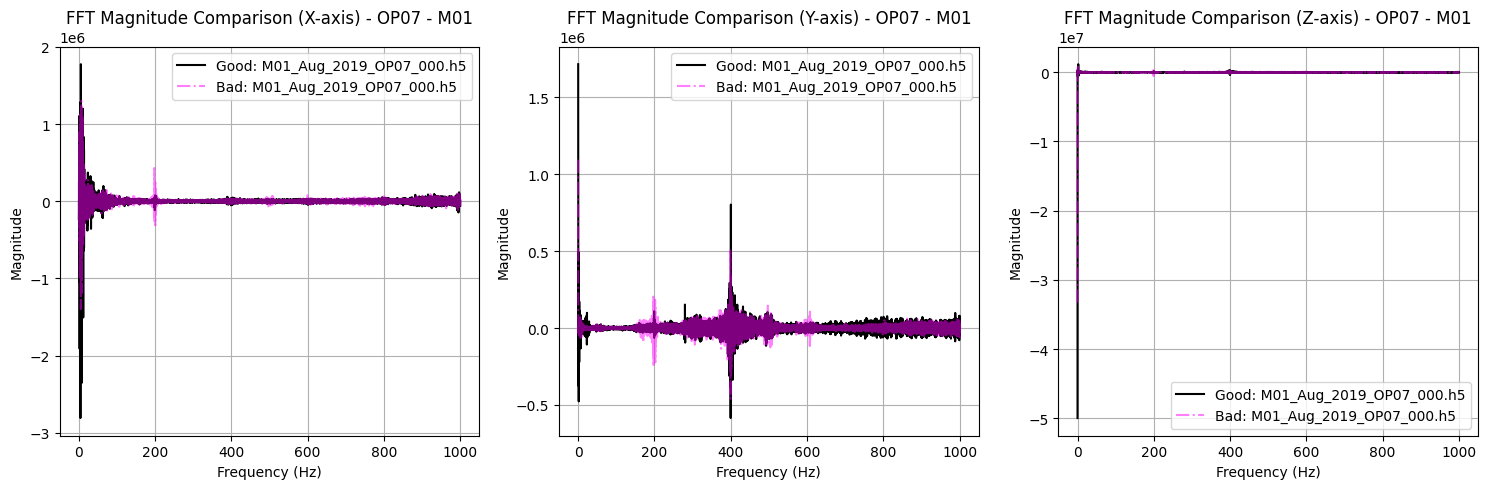

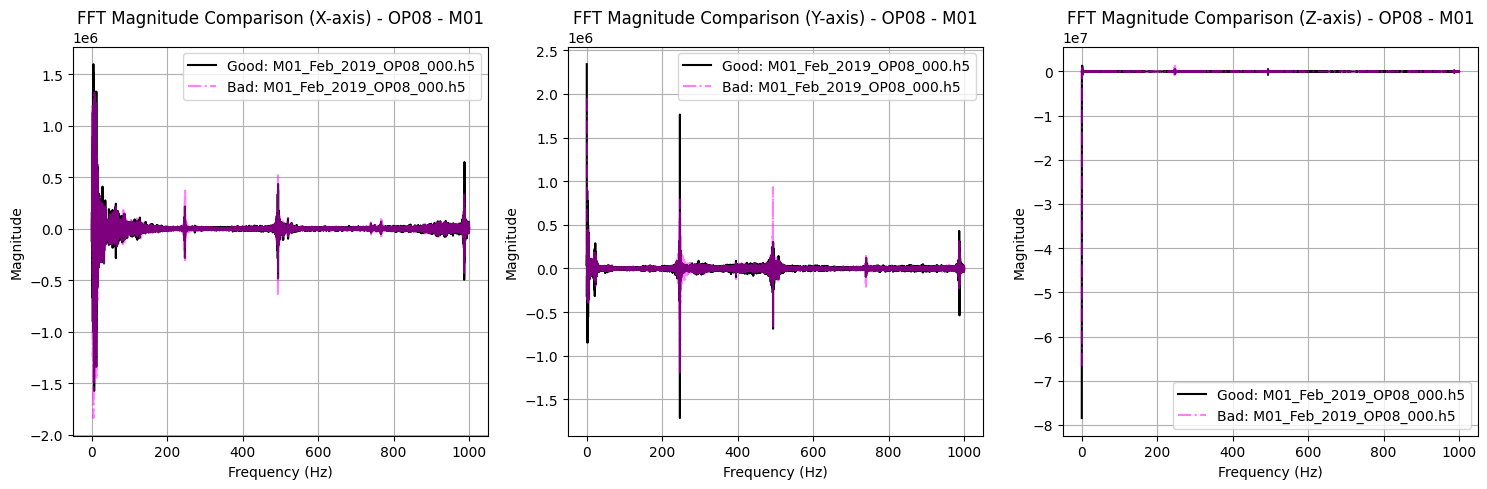

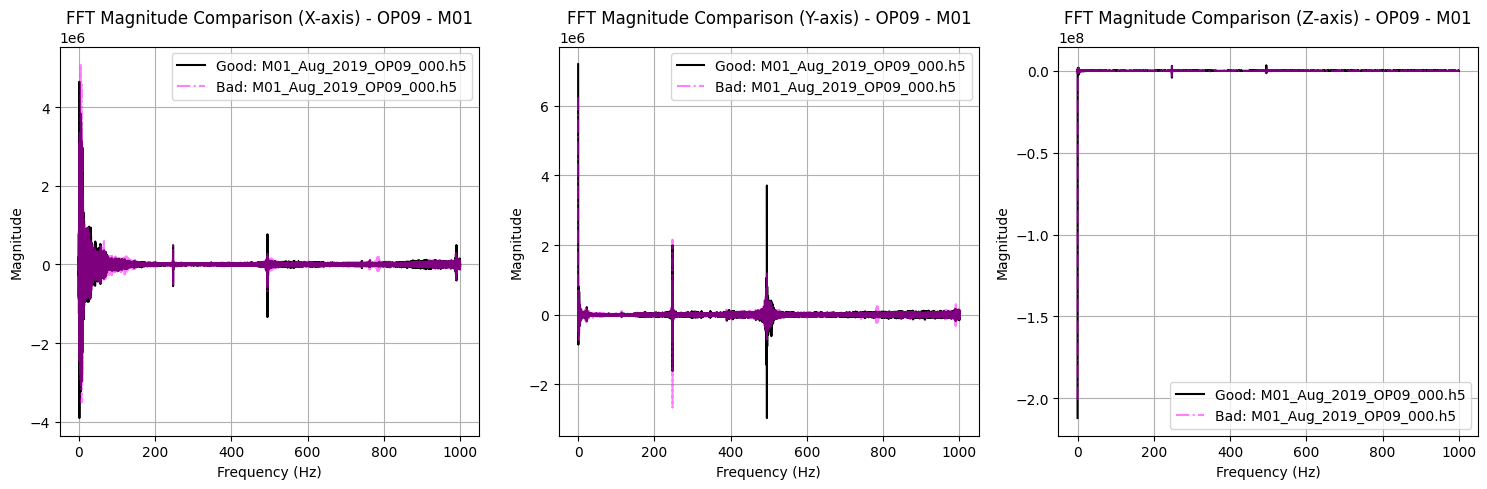

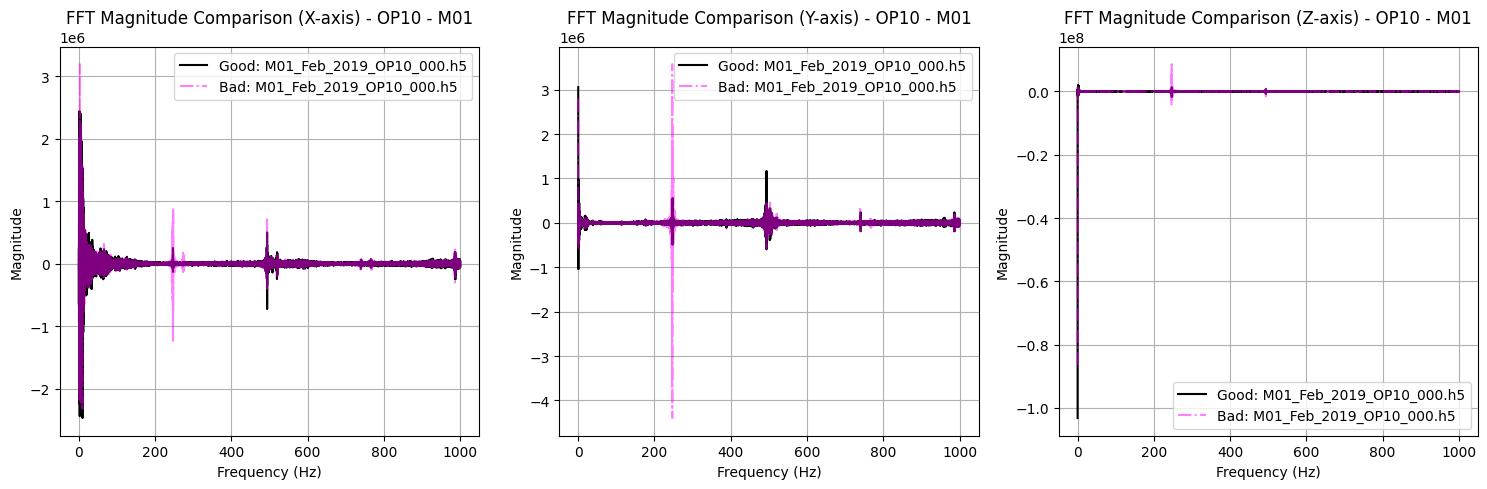

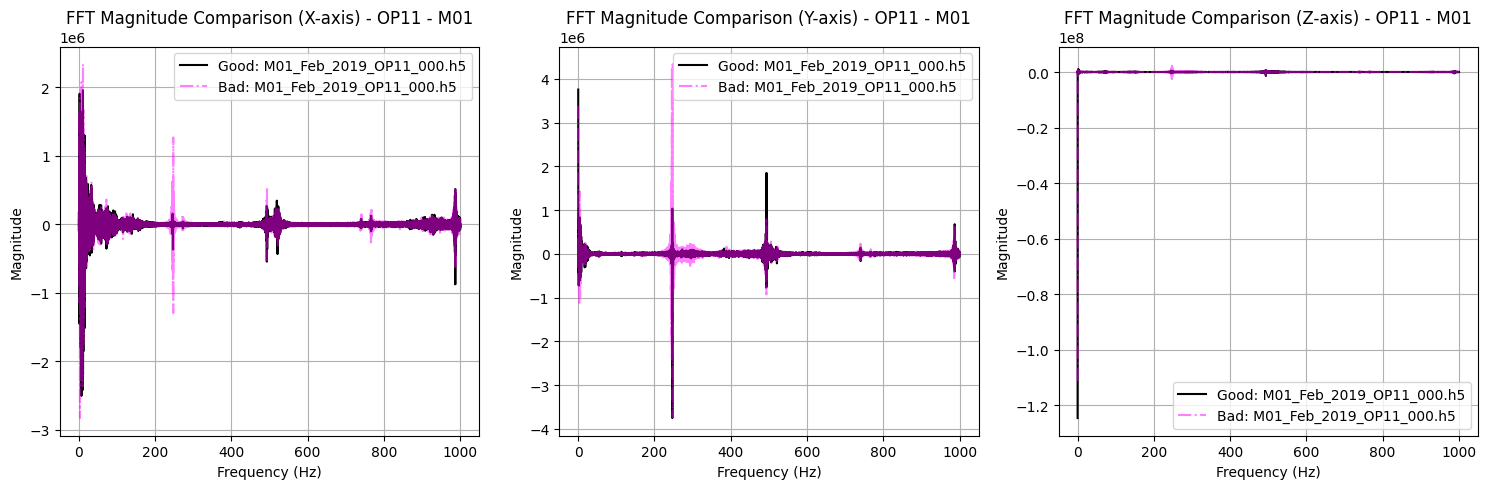

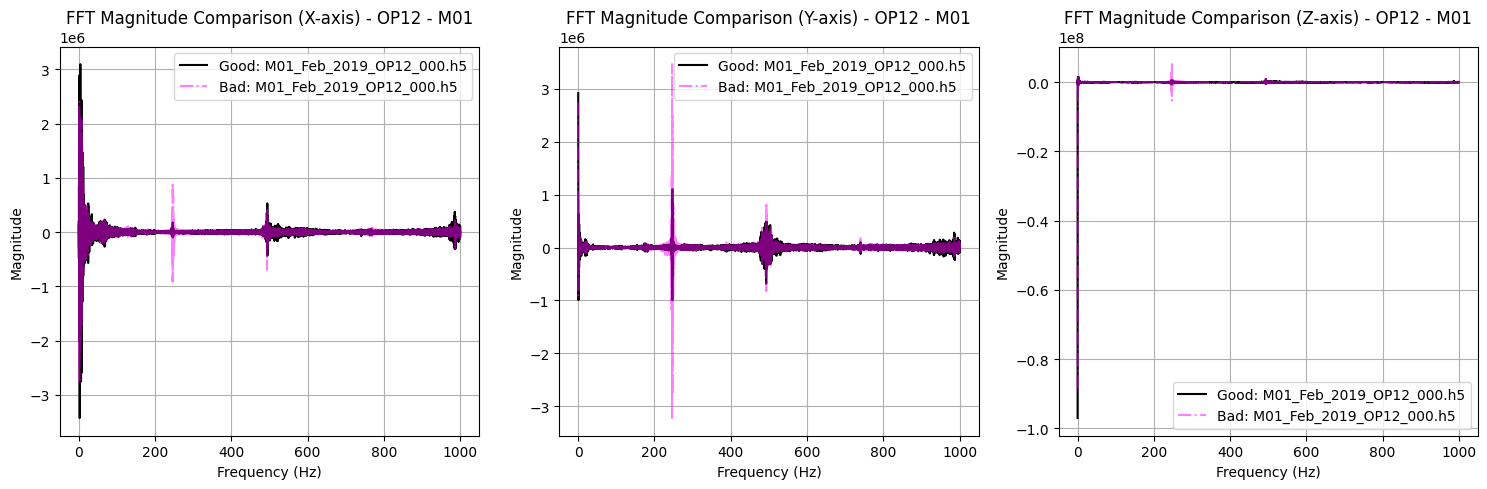

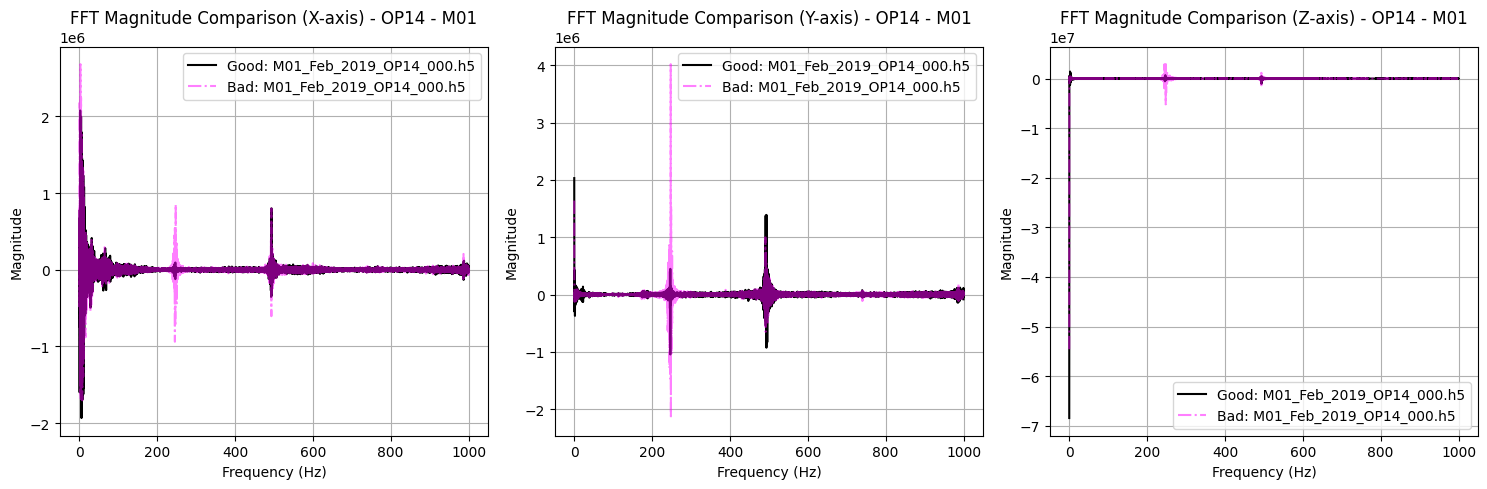

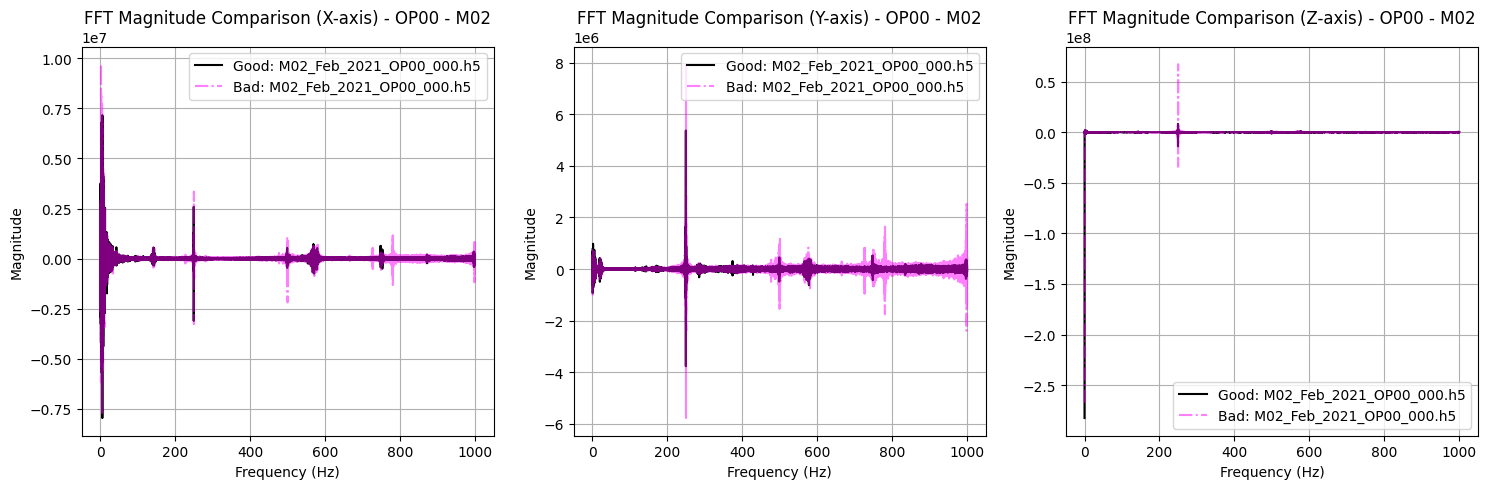

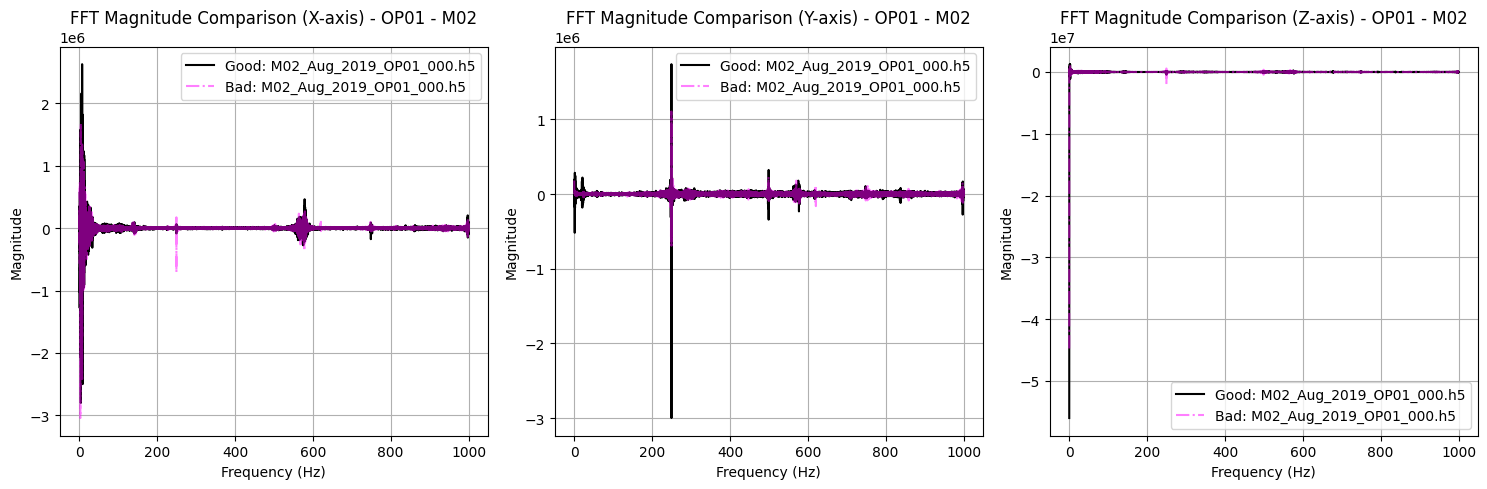

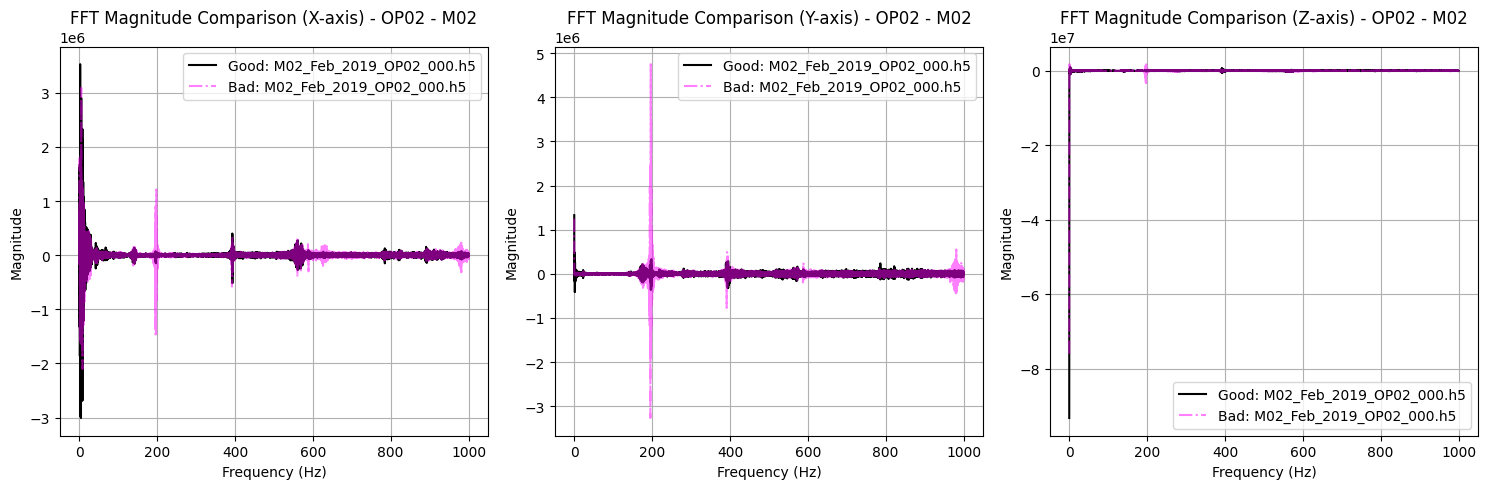

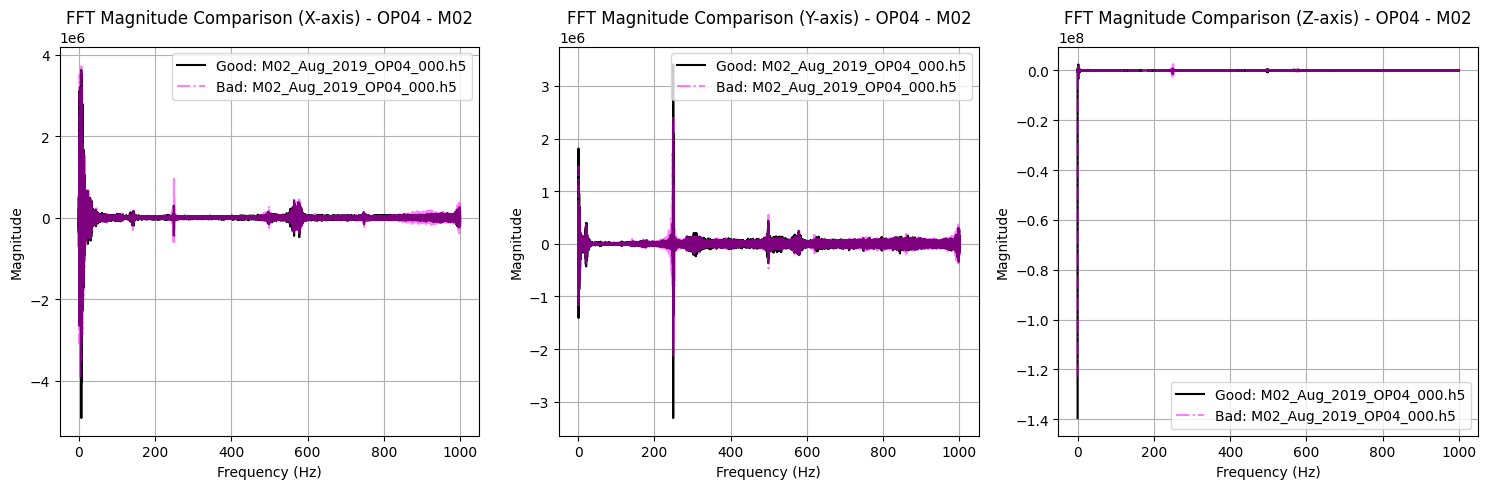

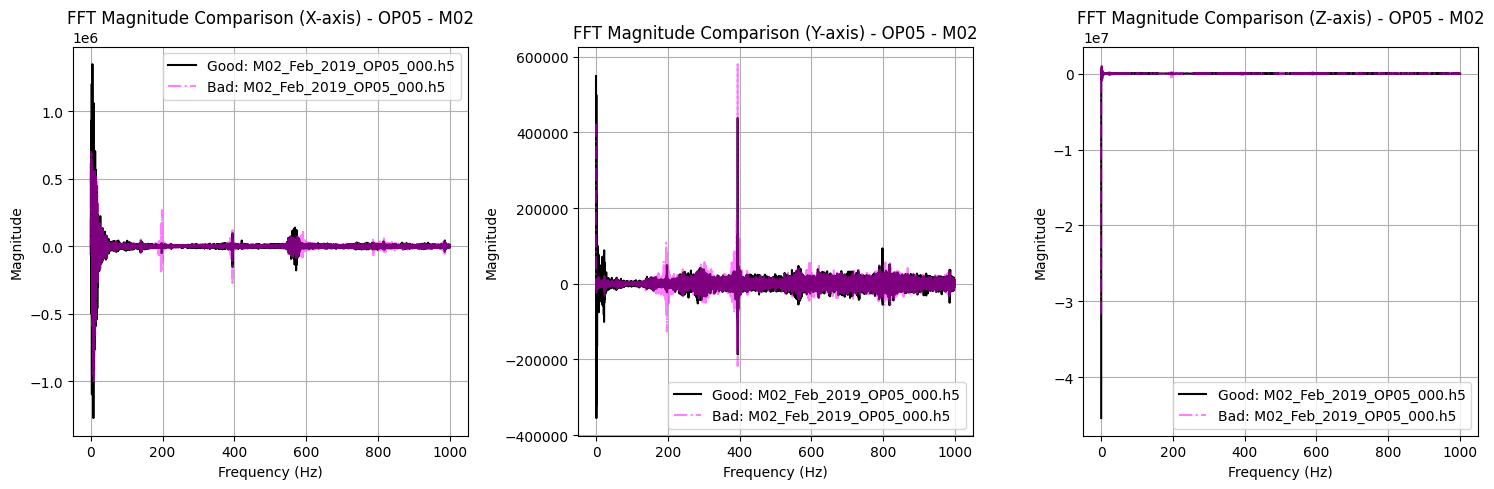

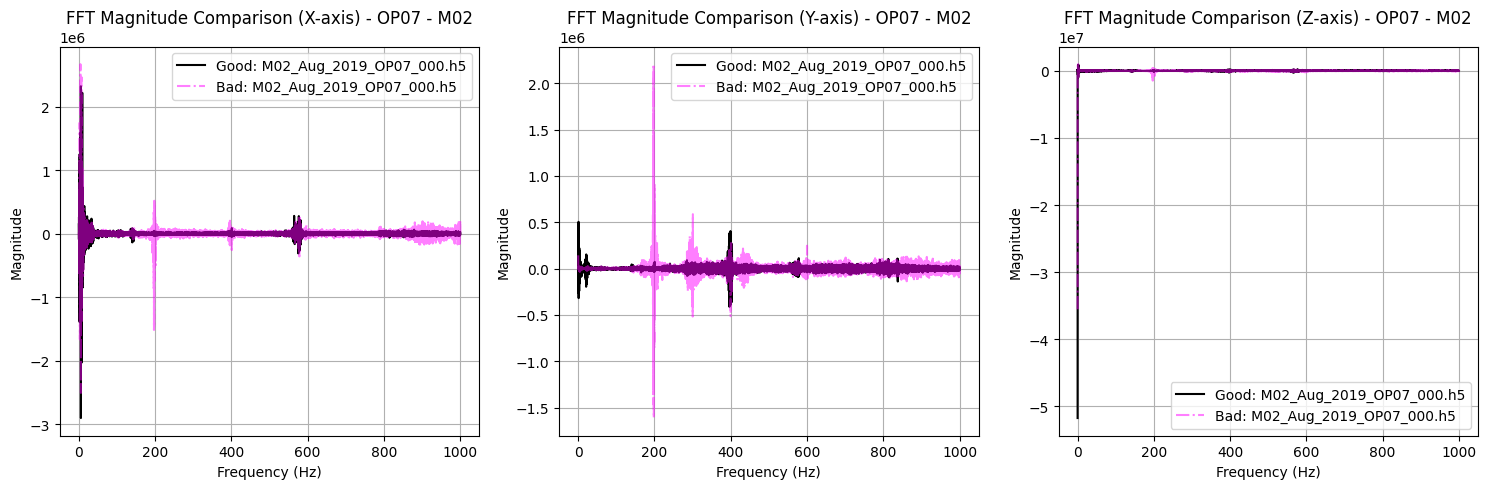

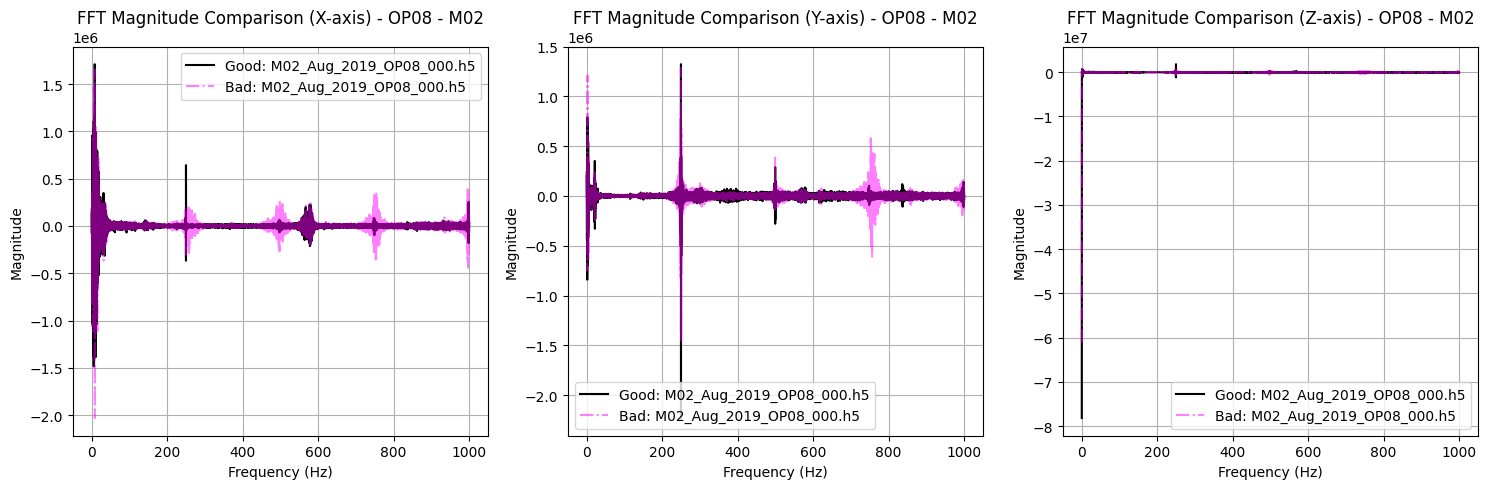

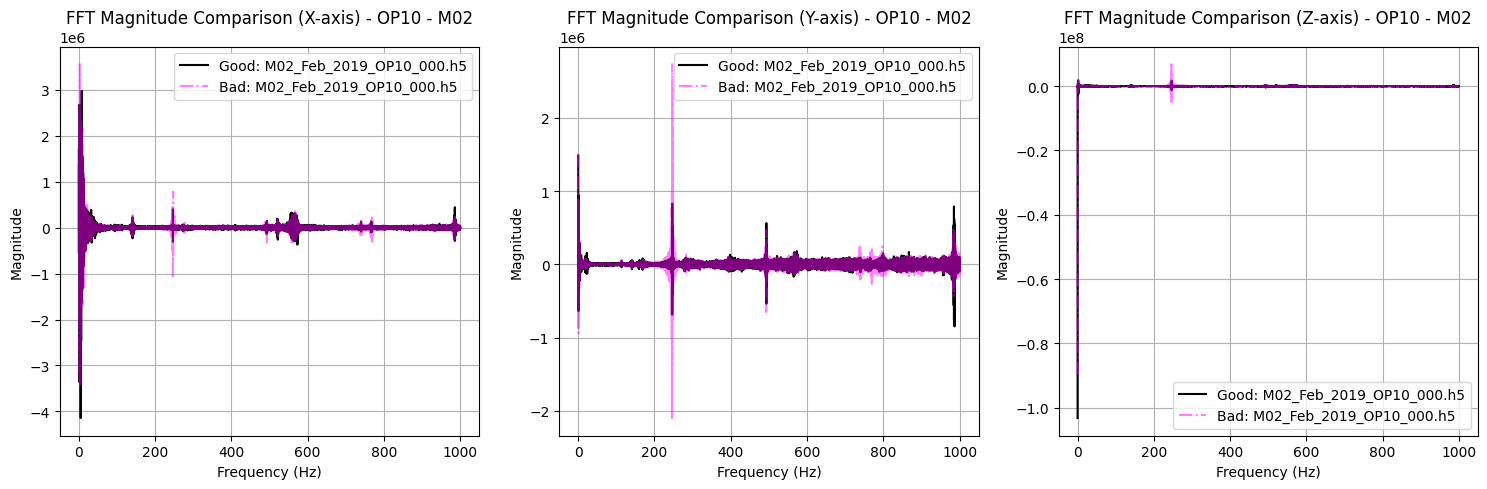

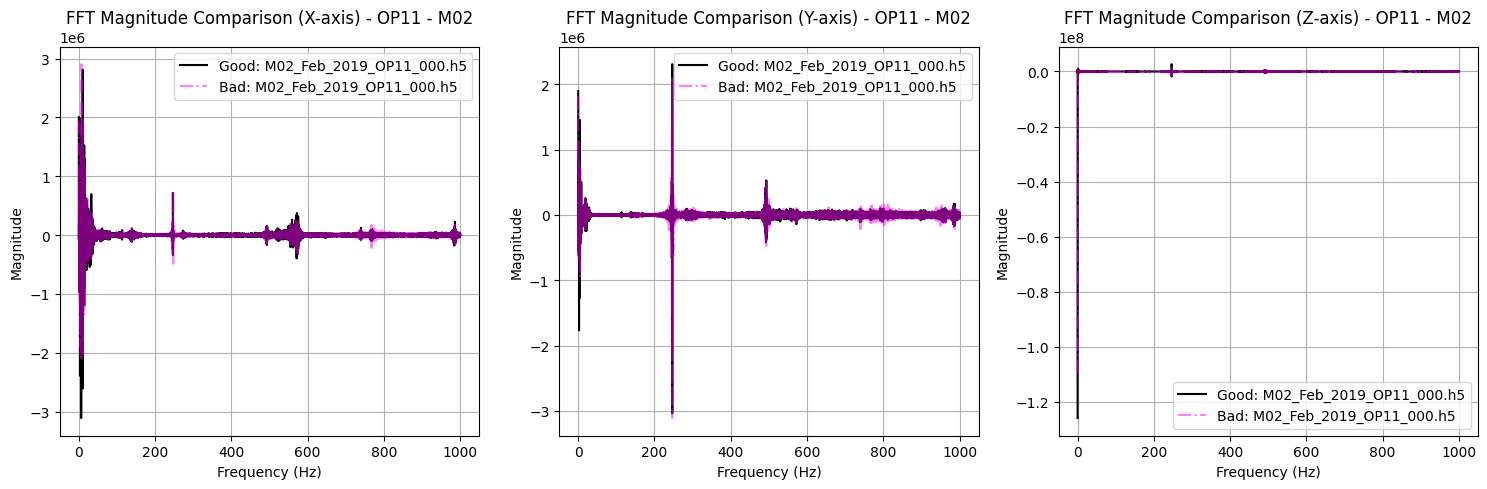

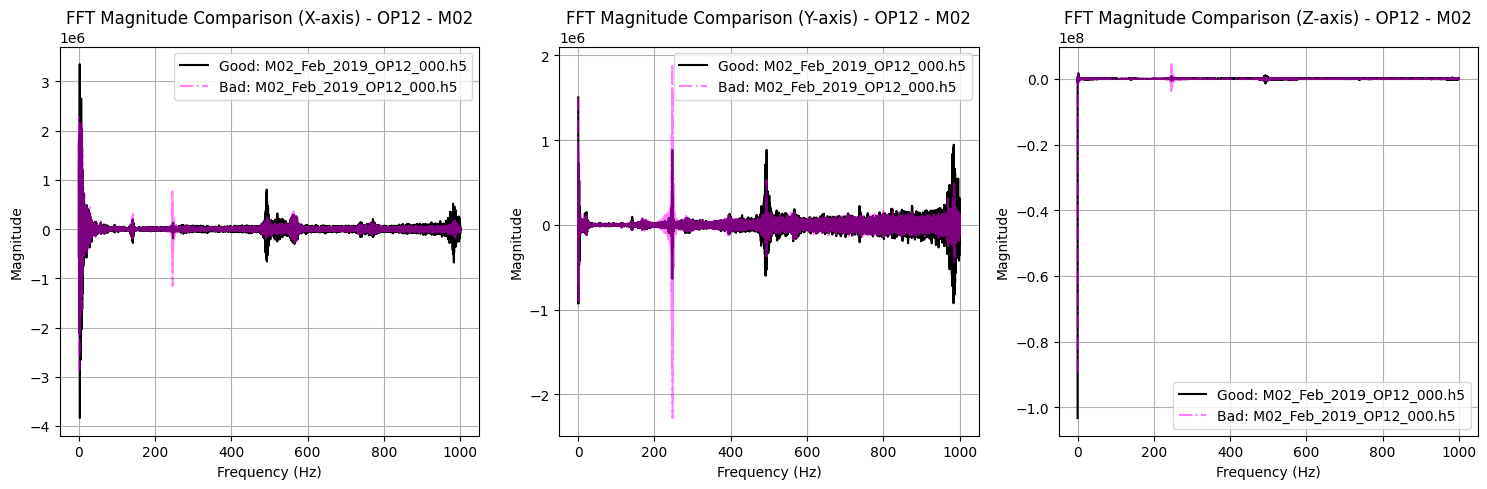

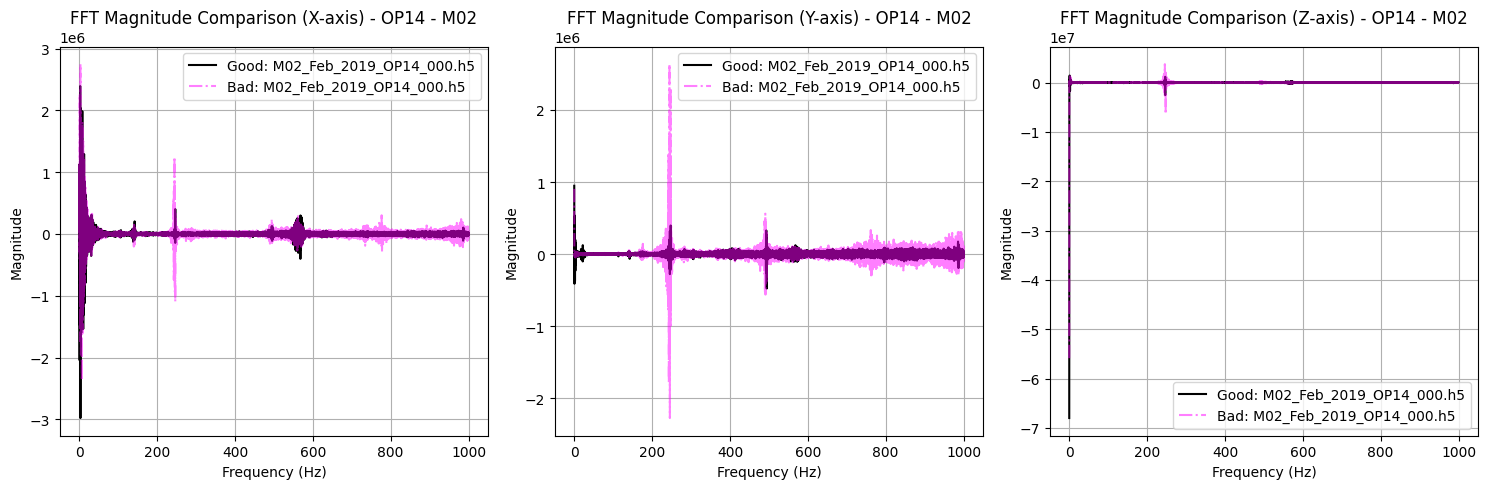

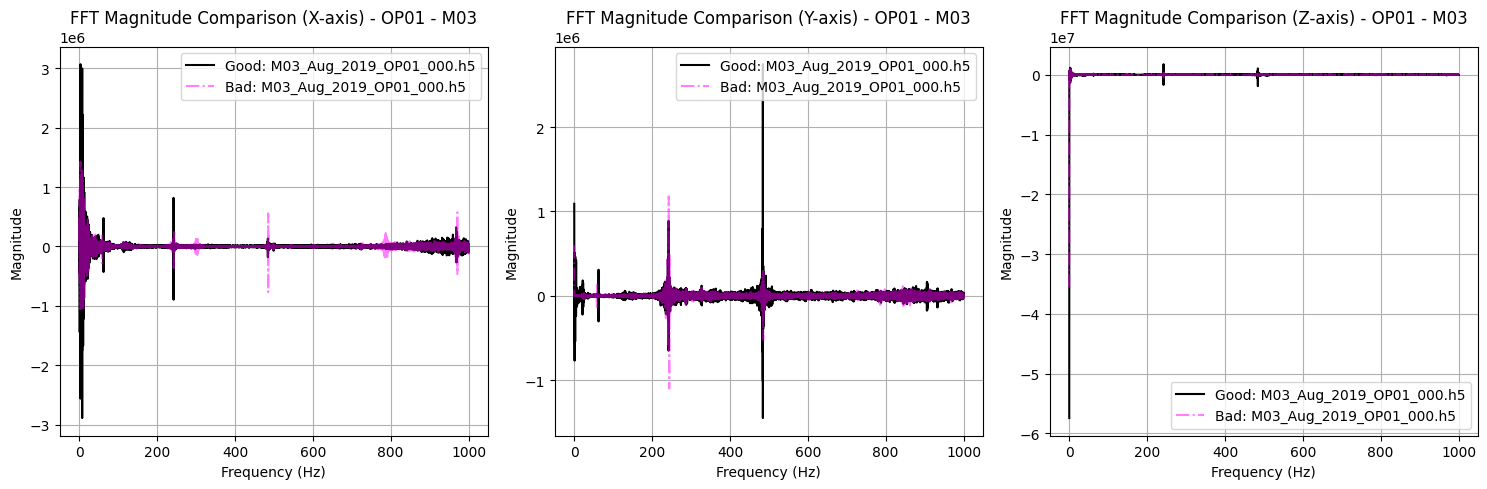

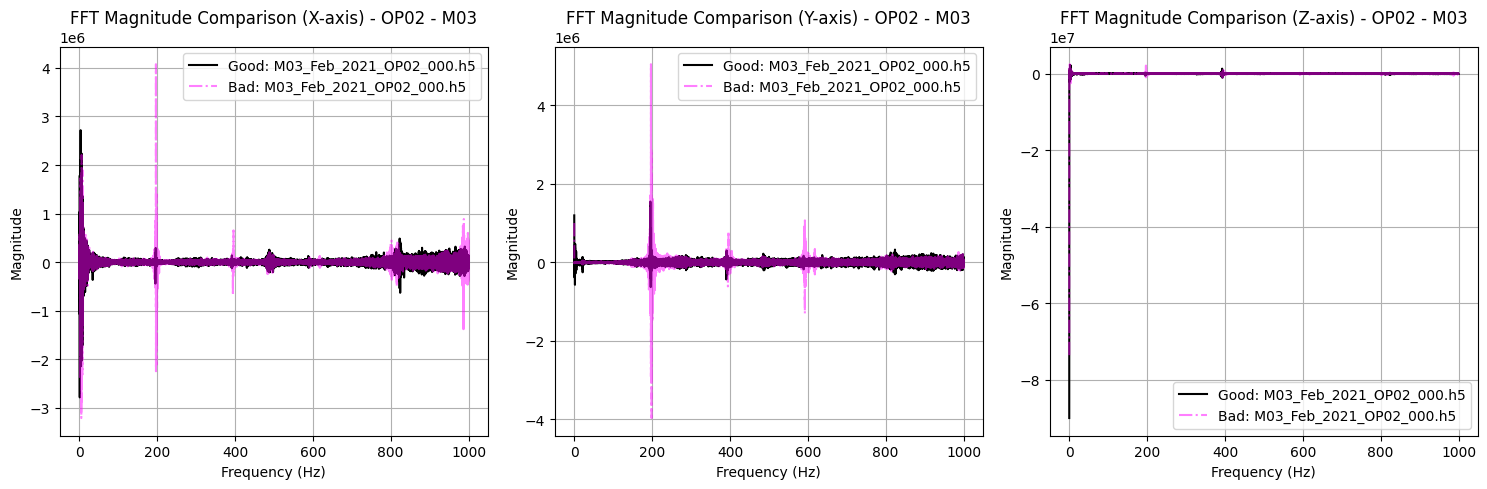

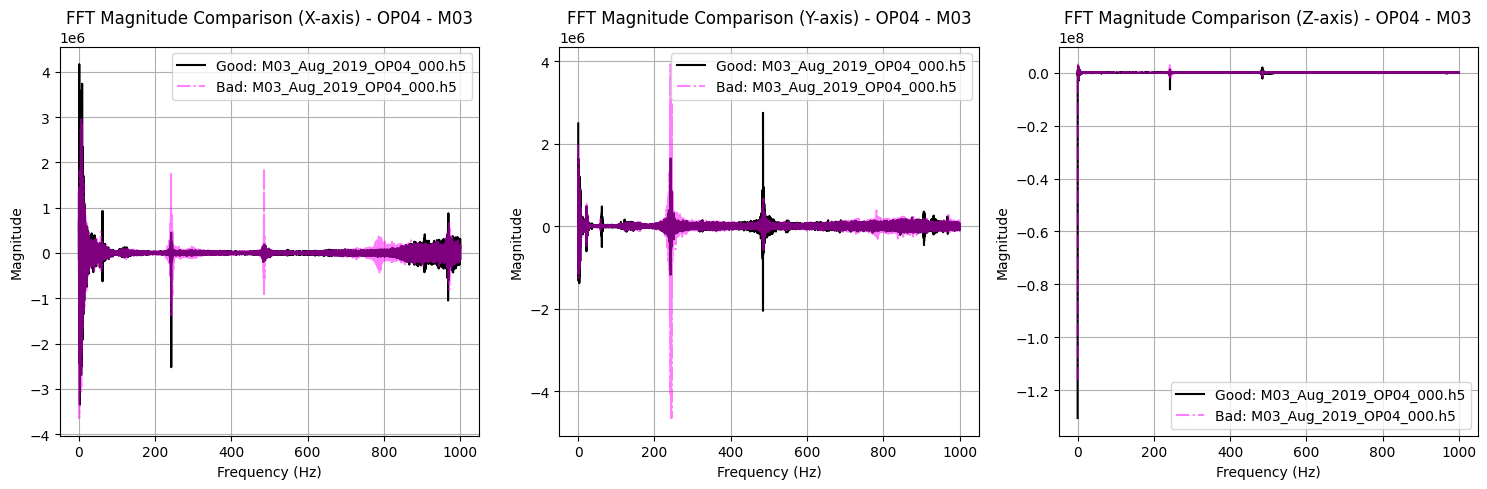

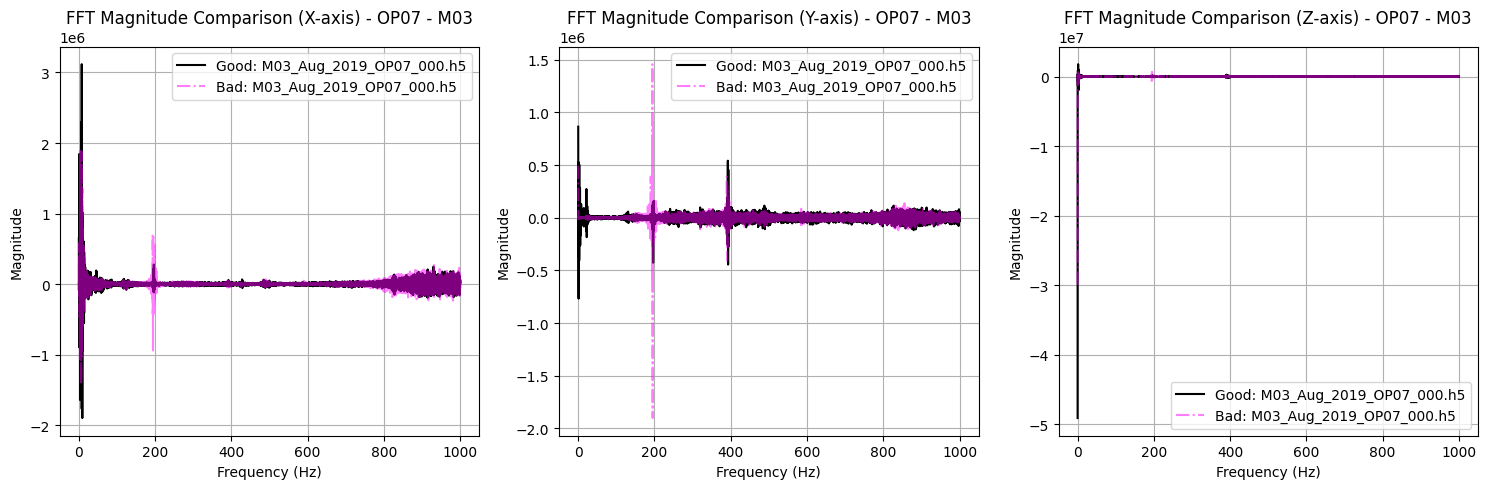

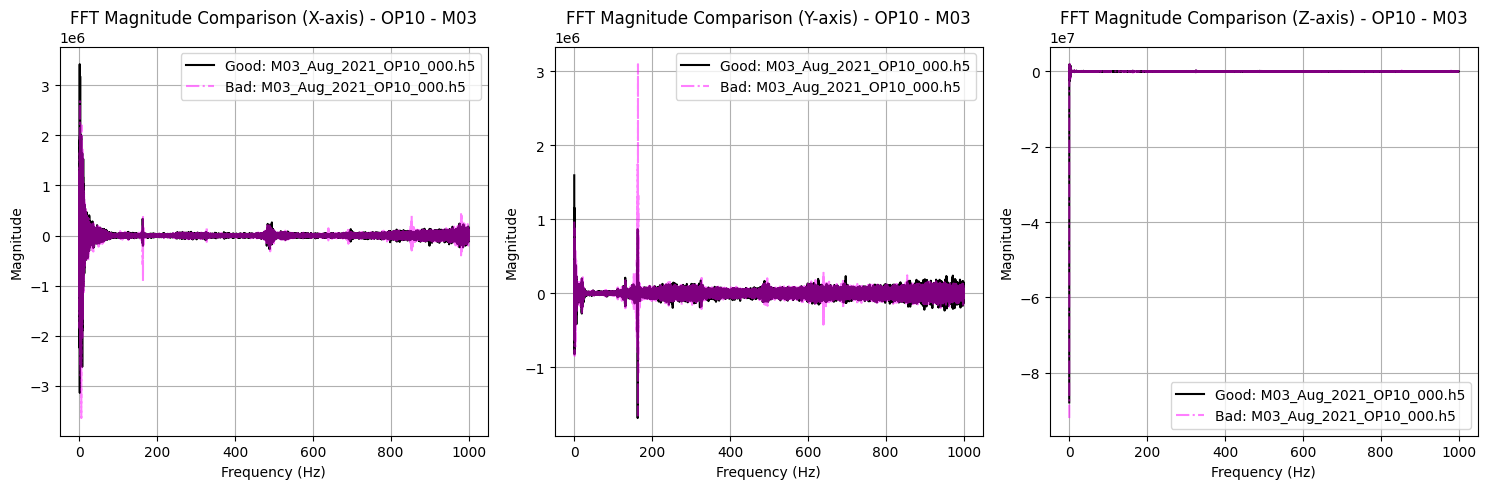

In [32]:
data_root = "../../cnc_data/Whole/"
sampling_freq = 2000
# Iterate through each machine and operation
for machine in machines:
    for operation in df_sorted[df_sorted['Machine'] == machine]['Operation']:
        bad_folder = os.path.join(data_root, machine, operation, 'bad')
        # Check if there are bad samples for the current operation
        if os.path.exists(bad_folder):
            # Get the list of bad files
            bad_files = [file for file in os.listdir(bad_folder) if file.endswith('.h5')]
            # Check if there are bad files for the current operation
            if bad_files:
                # Iterate through each bad sample
                for bad_file in bad_files:
                    # Extract the year and month from the bad file name
                    bad_year_month = bad_file.split('_')[1] + '_' + bad_file.split('_')[2]
                    # Find corresponding good samples based on the year and month
                    corresponding_good_files = [file for file in os.listdir(os.path.join(data_root, machine, operation, 'good')) if file.endswith('.h5') and bad_year_month in file]
                    if corresponding_good_files:
                        # Load vibration data for bad sample
                        with h5py.File(os.path.join(bad_folder, bad_file), 'r') as bad_h5:
                            bad_data_x = bad_h5['vibration_data'][:, 0]
                            bad_data_y = bad_h5['vibration_data'][:, 1]
                            bad_data_z = bad_h5['vibration_data'][:, 2]
                        # Compute FFT for bad sample (X-axis)
                        freqs_bad_x, magnitudes_bad_x = compute_fft(bad_data_x, sampling_freq)
                        freqs_bad_y, magnitudes_bad_y = compute_fft(bad_data_y, sampling_freq)
                        freqs_bad_z, magnitudes_bad_z = compute_fft(bad_data_z, sampling_freq)
                        # Load and compute FFT for corresponding good sample
                        with h5py.File(os.path.join(data_root, machine, operation, 'good', corresponding_good_files[0]), 'r') as good_h5:
                            good_data_x = good_h5['vibration_data'][:, 0]
                            good_data_y = good_h5['vibration_data'][:, 1]
                            good_data_z = good_h5['vibration_data'][:, 2]
                        # Compute FFT for good sample (X-axis)
                        freqs_good_x, magnitudes_good_x = compute_fft(good_data_x, sampling_freq)
                        freqs_good_y, magnitudes_good_y = compute_fft(good_data_y, sampling_freq)
                        freqs_good_z, magnitudes_good_z = compute_fft(good_data_z, sampling_freq)
                        # Get the names of the good and bad sample files
                        good_sample_name = corresponding_good_files[0]
                        bad_sample_name = bad_file
                        # Plot FFT magnitudes for comparison
                        plt.figure(figsize=(15, 5))
                        plt.subplot(1, 3, 1)
                        plt.plot(freqs_good_x, magnitudes_good_x, label=f'Good: {good_sample_name}', color='black')
                        plt.plot(freqs_bad_x, magnitudes_bad_x, label=f'Bad: {bad_sample_name}' , color='magenta', linestyle='dashdot', alpha=0.5)
                        plt.xlabel('Frequency (Hz)')
                        plt.ylabel('Magnitude')
                        plt.title(f'FFT Magnitude Comparison (X-axis) - {operation} - {machine}')
                        plt.legend()
                        plt.grid(True)
                        plt.subplot(1, 3, 2)
                        plt.plot(freqs_good_y, magnitudes_good_y, label=f'Good: {good_sample_name}', color='black')
                        plt.plot(freqs_bad_y, magnitudes_bad_y, label=f'Bad: {bad_sample_name}', color='magenta', linestyle='dashdot', alpha=0.5)
                        plt.xlabel('Frequency (Hz)')
                        plt.ylabel('Magnitude')
                        plt.title(f'FFT Magnitude Comparison (Y-axis) - {operation} - {machine}')
                        plt.legend()
                        plt.grid(True)
                        plt.subplot(1, 3, 3)
                        plt.plot(freqs_good_z, magnitudes_good_z, label=f'Good: {good_sample_name}', color='black')
                        plt.plot(freqs_bad_z, magnitudes_bad_z, label=f'Bad: {bad_sample_name}',color='magenta', linestyle='dashdot', alpha=0.5)
                        plt.xlabel('Frequency (Hz)')
                        plt.ylabel('Magnitude')
                        plt.title(f'FFT Magnitude Comparison (Z-axis) - {operation} - {machine}')
                        plt.legend()
                        plt.grid(True)
                        plt.tight_layout()
                        plt.show()
                        # Break out of the loop after plotting one set of plots for each operation and machine pair
                        break


In [53]:

# Define function to load data from .h5 file
def load_h5_file(filepath):
    with h5py.File(filepath, 'r') as f:
        data = f['vibration_data'][:]  # Assuming dataset is stored under 'data' key
    return data


# Define function to plot spectrograms in a 2-row, 3-column layout
def plot_spectrograms(good_data, bad_data, fs=2000):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, axis in enumerate(['X', 'Y', 'Z']):
        f_good, t_good, Sxx_good = spectrogram(good_data[:, i], fs, nperseg=256, noverlap=128)
        f_bad, t_bad, Sxx_bad = spectrogram(bad_data[:, i], fs, nperseg=256, noverlap=128)

        # Plot Good Sample
        axes[i].pcolormesh(t_good, f_good, 10 * np.log10(Sxx_good), shading='gouraud')
        axes[i].set_title(f'Good {axis}-Axis')
        axes[i].set_ylabel('Frequency [Hz]')
        axes[i].set_xlabel('Time [sec]')

        # Plot Bad Sample
        axes[i+3].pcolormesh(t_bad, f_bad, 10 * np.log10(Sxx_bad), shading='gouraud')
        axes[i+3].set_title(f'Bad {axis}-Axis')
        axes[i+3].set_ylabel('Frequency [Hz]')
        axes[i+3].set_xlabel('Time [sec]')

    plt.tight_layout()
    plt.colorbar(axes[2].collections[0], ax=axes, orientation='vertical', fraction=0.02)
    plt.show()




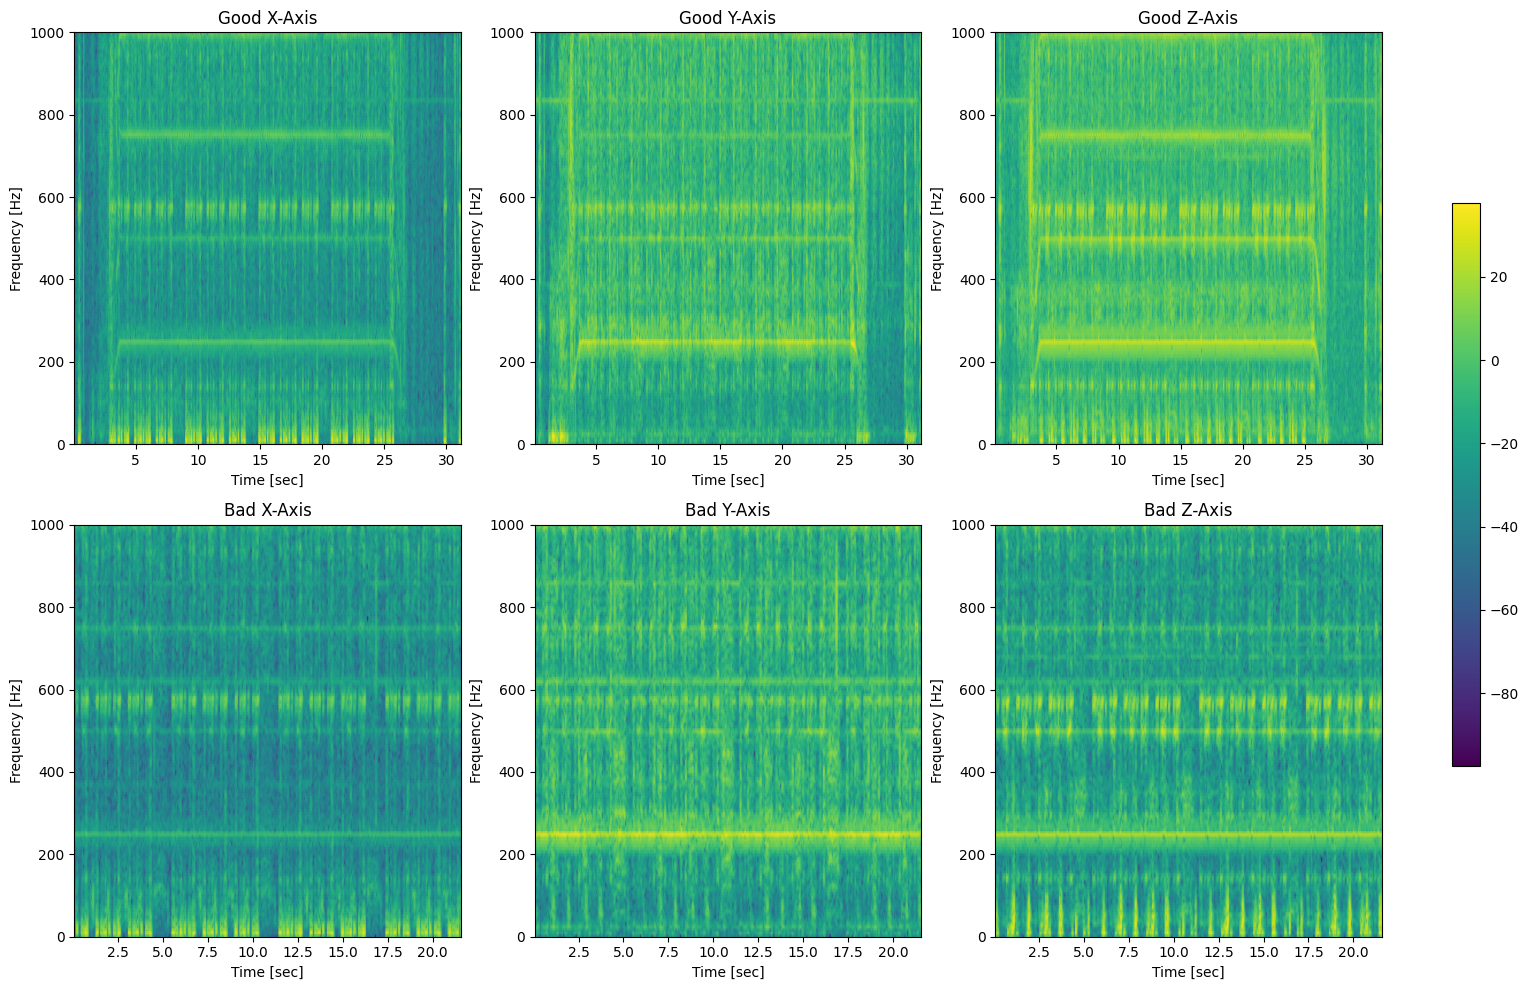

In [54]:
# Example usage
path_to_good_file = "../../cnc_data/Whole/M02/OP01/good/M02_Feb_2021_OP01_001.h5"  # Replace with actual path
path_to_bad_file = "../../cnc_data/Whole/M02/OP01/bad/M02_Aug_2019_OP01_000.h5"    # Replace with actual path


good_data = load_h5_file(path_to_good_file)
bad_data = load_h5_file(path_to_bad_file)

# Plot spectrogram for X, Y, Z axes (assuming 3-axis data)

# Plot all spectrograms in a 2-row, 3-column layout
plot_spectrograms(good_data, bad_data)


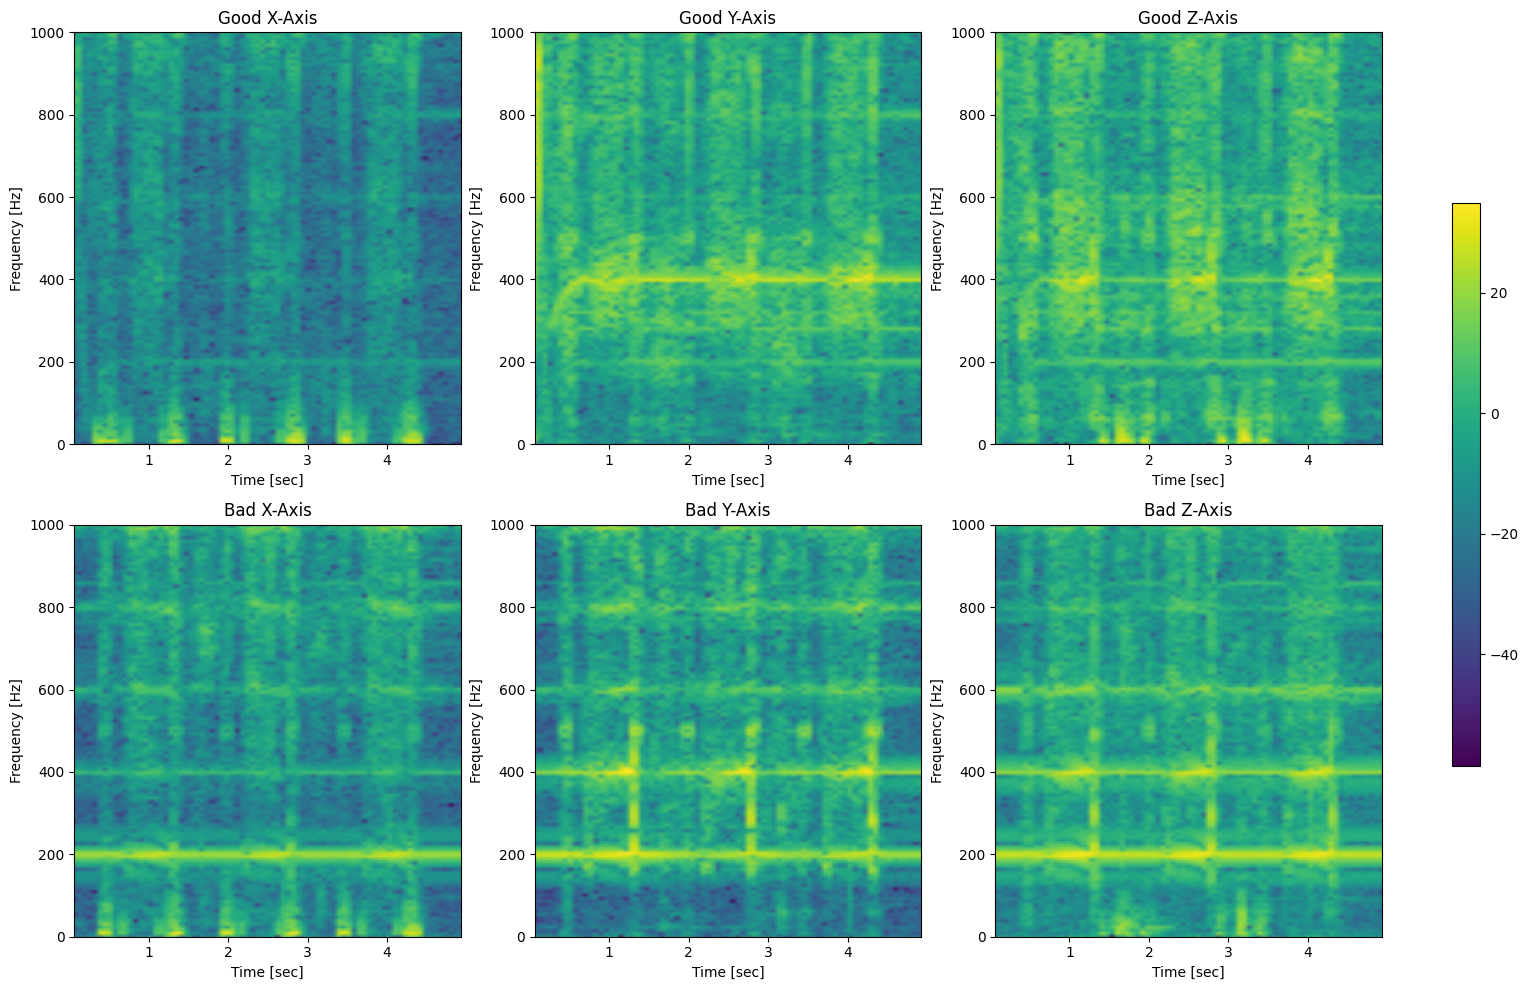

In [60]:

# Example usage
path_to_good_file_1 = "../data/final/Selected_data_windowed_grouped/good/M01_Aug_2019_OP07_004_window_0.h5"  # Replace with actual path
path_to_bad_file_1 = "../data/final/Selected_data_windowed_grouped/bad/M01_Aug_2021_OP07_001_window_1.h5"    # Replace with actual path



good_data_1 = load_h5_file(path_to_good_file_1)
bad_data_1 = load_h5_file(path_to_bad_file_1)

# Plot spectrogram for X, Y, Z axes (assuming 3-axis data)

# Plot all spectrograms in a 2-row, 3-column layout
plot_spectrograms(good_data_1, bad_data_1)

In [33]:
def load_data(file_path):
    """
    Load vibration data from an HDF5 file.
    """
    with h5py.File(file_path, 'r') as file:
        df = file['vibration_data'][:]
    return pd.DataFrame({'X': df[:, 0], 'Y': df[:, 1], 'Z': df[:, 2]})

load_data('./data/final/Selected_data/M01/OP01/bad/M01_Aug_2019_OP01_000.h5')

In [34]:
# Define the root data directories and configurations
data_root = Path("../../cnc_data/Whole/")
selected_operations = ['OP01', 'OP02', 'OP04', 'OP07', 'OP10']
machines = ['M01', 'M02', 'M03']
window_save_root = Path("../data/other_ways/windows_selected")
window_size = 10000  # 5 seconds * 2000Hz = 10000 data points

In [35]:

def trim_and_window(time_series, label):
    """
    Trim the time series based on the label ("GOOD" or "BAD") and create 5-second windows.
    
    Args:
        time_series (np.array): The time series data (1D array).
        label (str): "GOOD" or "BAD" indicating the class of the time series.
        
    Returns:
        List of 5-second windows.
    """
    total_len = time_series.shape[0]  # Total number of data points
    n_windows = total_len // window_size  # Number of full windows
    remainder = total_len % window_size  # Remaining points after full windows
    
    print(f"Total length of time series: {total_len} data points")
    print(f"Number of full windows: {n_windows}, Remainder: {remainder} data points")
    
    if label == 'BAD':
        # For BAD class: trim remainder from both sides
        trim_amount = remainder // 2
        print(f"Trimming {trim_amount} data points from each side for BAD class")
        trimmed_series = time_series[trim_amount:total_len - trim_amount]
    
    elif label == 'GOOD':
        # For GOOD class: add another 5-second window if remainder exists
        if remainder > 0:
            print("Adding another window for GOOD class due to leftover")
            remainder += window_size
        trim_amount = remainder // 2
        print(f"Trimming {trim_amount} data points from each side for GOOD class")
        trimmed_series = time_series[trim_amount:total_len - trim_amount]
    
    print(f"Trimmed time series length: {len(trimmed_series)} data points")

    # Now split the trimmed series into 5-second windows
    windows = [trimmed_series[i:i + window_size] for i in range(0, len(trimmed_series) - window_size + 1, window_size)]
    print(f"Number of 5-second windows created: {len(windows)}")
    
    return windows

In [27]:
def process_and_save_windows(machine, operation, label, folder):
    """
    Processes and saves the 5-second windows for a given machine, operation, and label (GOOD or BAD) as .h5 files.
    
    Args:
        machine (str): Machine ID (e.g., 'M01').
        operation (str): Operation ID (e.g., 'OP01').
        label (str): 'good' or 'bad'.
        folder (Path): Path to the 'good' or 'bad' folder.
    """
    # Create save directory
    save_dir = window_save_root / machine / operation / label
    save_dir.mkdir(parents=True, exist_ok=True)
    print(f"Processing {label.upper()} files in {folder}")

    # Process each h5 file in the folder
    for h5_file in folder.glob("*.h5"):
        print(f"Processing file: {h5_file}")
        with h5py.File(h5_file, 'r') as f:
            if 'vibration_data' not in f:
                print(f"No 'vibration_data' dataset in file: {h5_file}")
                continue

            vibration_data = f['vibration_data'][:]
            print(f"Loaded time series data of shape {vibration_data.shape}")

            # Trim and create windows
            windows = trim_and_window(vibration_data, label.upper())
            
            # Save each window as a new .h5 file
            for idx, window in enumerate(windows):
                window_filename = save_dir / f"{h5_file.stem}_window_{idx}.h5"
                with h5py.File(window_filename, 'w') as hf:
                    hf.create_dataset('vibration_data', data=window)
                    print(f"Saved window {idx} for {h5_file.stem} to {window_filename}")

In [91]:
# Iterate over machines, operations, and good/bad data
for machine in machines:
    for operation in selected_operations:
        bad_folder = Path(data_root) / machine / operation / 'bad'
        good_folder = Path(data_root) / machine / operation / 'good'
        
        if bad_folder.exists():
            process_and_save_windows(machine, operation, 'bad', bad_folder)
        else:
            print(f"Bad folder not found: {bad_folder}")
        
        if good_folder.exists():
            process_and_save_windows(machine, operation, 'good', good_folder)
        else:
            print(f"Good folder not found: {good_folder}")


Processing BAD files in data/balanced_data_separate/M01/OP01/bad
Processing file: data/balanced_data_separate/M01/OP01/bad/M01_Feb_2019_OP01_000.h5
Loaded time series data of shape (47081, 3)
Total length of time series: 47081 data points
Number of full windows: 4, Remainder: 7081 data points
Trimming 3540 data points from each side for BAD class
Trimmed time series length: 40001 data points
Number of 5-second windows created: 4
Saved window 0 for M01_Feb_2019_OP01_000 to data/windows_selected/M01/OP01/bad/M01_Feb_2019_OP01_000_window_0.h5
Saved window 1 for M01_Feb_2019_OP01_000 to data/windows_selected/M01/OP01/bad/M01_Feb_2019_OP01_000_window_1.h5
Saved window 2 for M01_Feb_2019_OP01_000 to data/windows_selected/M01/OP01/bad/M01_Feb_2019_OP01_000_window_2.h5
Saved window 3 for M01_Feb_2019_OP01_000 to data/windows_selected/M01/OP01/bad/M01_Feb_2019_OP01_000_window_3.h5
Processing file: data/balanced_data_separate/M01/OP01/bad/M01_Aug_2019_OP01_000.h5
Loaded time series data of shape

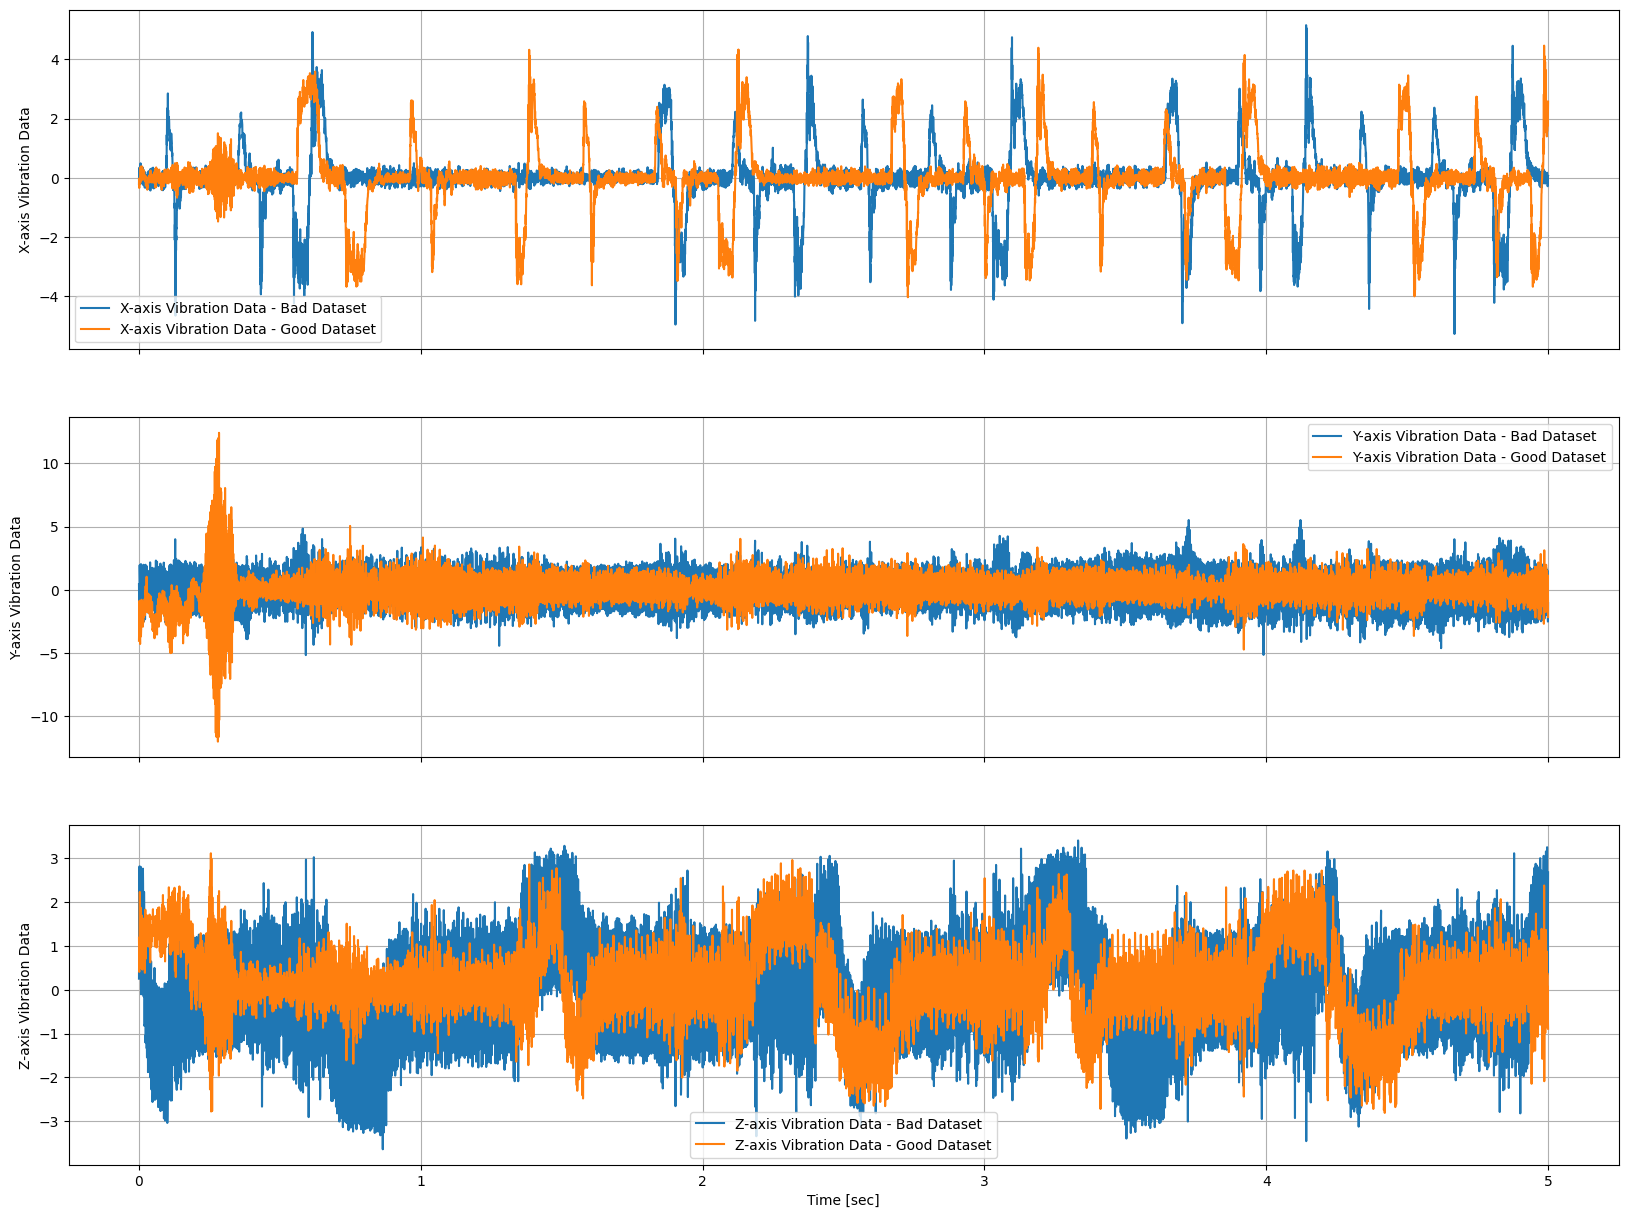

In [36]:
# Example of the trimeed daataset:
files=['../data/final/Selected_data_windowed_grouped_normalized/bad/M01_Aug_2019_OP01_000_window_0.h5', '../data/final/Selected_data_windowed_grouped_normalized/good/M01_Aug_2019_OP01_004_window_0.h5']
dataset_labels = ["Bad Dataset", "Good Dataset"]  # Add labels for your datasets

data = datafile_read(files, dataset_labels)


In [37]:

# Define the root directory where your data is stored
data_root = "./data/final/Selected_data"

def find_all_h5s_in_dir(s_dir):
    """
    list all .h5 files in a directory
    """

    fileslist = []
    for root, dirs, files in os.walk(s_dir):
        for file in files:
            if file.endswith(".h5"):
                fileslist.append(file)
    return fileslist


# Define a function to load H5 files and calculate the duration in seconds
def load_h5_files_and_calculate_duration(data_root):
    data_list = []
    labels = []

    for machine in ['M01', 'M02', 'M03']:
        for operation in os.listdir(os.path.join(data_root, machine)):
            if os.path.isdir(os.path.join(data_root, machine, operation)):
                for label in ['good', 'bad']:
                    data_path = os.path.join(data_root, machine, operation, label)
                    files = find_all_h5s_in_dir(data_path)

                    for file in files:
                        file_path = os.path.join(data_path, file)
                        with h5py.File(file_path, 'r') as f:
                            vibration_data = f['vibration_data'][:]
                            samples_s = len(vibration_data) / 2000  # Assuming a data sampling frequency of 2000 Hz

                        data_list.append({
                            'Machine': machine,
                            'Operation': operation,
                            'Sample Type': label,
                            'File Name': file,
                            'Duration (s)': samples_s
                        })

    return data_list

# Create a DataFrame
data_list = load_h5_files_and_calculate_duration(data_root)
df = pd.DataFrame(data_list)

# Print the DataFrame
print(df)



     Machine Operation Sample Type                 File Name  Duration (s)
0        M01      OP00        good  M01_Aug_2019_OP00_000.h5       134.144
1        M01      OP00        good  M01_Aug_2019_OP00_001.h5       134.144
2        M01      OP00        good  M01_Aug_2019_OP00_003.h5       134.144
3        M01      OP00        good  M01_Aug_2019_OP00_004.h5       132.096
4        M01      OP00        good  M01_Aug_2019_OP00_005.h5       134.144
...      ...       ...         ...                       ...           ...
1697     M03      OP13        good  M03_Feb_2020_OP13_012.h5        33.280
1698     M03      OP13        good  M03_Feb_2020_OP13_013.h5        33.280
1699     M03      OP13        good  M03_Feb_2021_OP13_000.h5        33.280
1700     M03      OP13        good  M03_Feb_2021_OP13_001.h5        33.280
1701     M03      OP13        good  M03_Feb_2021_OP13_002.h5        31.744

[1702 rows x 5 columns]


In [93]:
csv_filename = 'dataset_window_info.csv'
df.to_csv(csv_filename, index=False)

# Print a message to confirm the file has been saved
print(f"DataFrame saved to {csv_filename}")

DataFrame saved to dataset_window_info.csv


In [28]:
# Load your CSV (if it's not already loaded into a DataFrame)
csv_filename = 'dataset_window_info.csv'
df = pd.read_csv(csv_filename)

# Count the number of "good" and "bad" samples
sample_counts = df['Sample Type'].value_counts()

# Print the counts
print("Sample Type Counts:")
print(sample_counts)

Sample Type Counts:
Sample Type
good    465
bad     219
Name: count, dtype: int64


In [29]:
# Alternatively, you can group by 'Sample Type' for a more complex analysis
grouped_counts = df.groupby(['Machine', 'Sample Type']).size()

print("\nSample counts per machine:")
print(grouped_counts)


Sample counts per machine:
Machine  Sample Type
M01      bad             78
         good           174
M02      bad             86
         good           181
M03      bad             55
         good           110
dtype: int64


In [31]:


# Define a function to balance the dataset
def balance_dataset(machines, selected_operations, data_root):
    balanced_data = []
    balanced_data_dir = Path(data_root) / "windows_selected_separate"
    balanced_data_dir.mkdir(exist_ok=True)
    print(f"Directory '{balanced_data_dir}' created")

    bad_data_dir = balanced_data_dir / "bad"
    good_data_dir = balanced_data_dir / "good"

    bad_data_dir.mkdir(exist_ok=True)
    print(f"Directory '{bad_data_dir}' created")

    good_data_dir.mkdir(exist_ok=True)
    print(f"Directory '{good_data_dir}' created")

    for machine in machines:
        for operation in selected_operations:
            bad_folder = Path(data_root) / machine / operation / 'bad'
            good_folder = Path(data_root) / machine / operation / 'good'
        
            # Get the list of bad files
            bad_files = [file for file in bad_folder.iterdir() if file.is_file() and file.suffix == '.h5']

            for file in bad_files:
                dest_bad = bad_data_dir / file.name
                try:
                    shutil.copy2(file, dest_bad)
                    print(f"Copied '{file}' to '{dest_bad}'")
                except shutil.Error as e:
                    print(f"Error occurred while copying file: {e}")
                except IOError as e:
                    print(f"Error occurred while accessing file: {e.strerror}")

                balanced_data.append((machine, operation, 'bad', file.name))

            # Get the list of good files
            good_files = [file for file in good_folder.iterdir() if file.is_file() and file.suffix == '.h5']

            for file in good_files:
                dest_good = good_data_dir / file.name
                try:
                    shutil.copy2(file, dest_good)
                    print(f"Copied '{file}' to '{dest_good}'")
                except shutil.Error as e:
                    print(f"Error occurred while copying file: {e}")
                except IOError as e:
                    print(f"Error occurred while accessing file: {e.strerror}")

                balanced_data.append((machine, operation, 'good', file.name))

    return balanced_data

# Step 1: Data Preparation
selected_operations = ['OP01', 'OP02', 'OP04', 'OP07', 'OP10']
machines = ['M01', 'M02', 'M03']
data_root = Path("../data/other_ways/windows_selected")

balanced_data = balance_dataset(machines, selected_operations, data_root)
print(len(balanced_data), balanced_data)

Directory 'data/windows_selected/windows_selected_separate' created
Directory 'data/windows_selected/windows_selected_separate/bad' created
Directory 'data/windows_selected/windows_selected_separate/good' created
Copied 'data/windows_selected/M01/OP01/bad/M01_Feb_2019_OP01_000_window_0.h5' to 'data/windows_selected/windows_selected_separate/bad/M01_Feb_2019_OP01_000_window_0.h5'
Copied 'data/windows_selected/M01/OP01/bad/M01_Feb_2019_OP01_000_window_1.h5' to 'data/windows_selected/windows_selected_separate/bad/M01_Feb_2019_OP01_000_window_1.h5'
Copied 'data/windows_selected/M01/OP01/bad/M01_Aug_2019_OP01_000_window_1.h5' to 'data/windows_selected/windows_selected_separate/bad/M01_Aug_2019_OP01_000_window_1.h5'
Copied 'data/windows_selected/M01/OP01/bad/M01_Feb_2019_OP01_000_window_2.h5' to 'data/windows_selected/windows_selected_separate/bad/M01_Feb_2019_OP01_000_window_2.h5'
Copied 'data/windows_selected/M01/OP01/bad/M01_Aug_2019_OP01_000_window_2.h5' to 'data/windows_selected/windows